# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from itertools import combinations
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
sklearn.set_config(display = 'Test')

# Functions

## Data Visualization Funtions

In [2]:
def percent_missing(df):
    
    temp_df = pd.DataFrame((df.isnull().sum()/len(df)*100).astype(int), columns = ['Percent Missing'])
    
    missing_rows = temp_df.loc[temp_df['Percent Missing'] != 0]
    
    if len(missing_rows) > 0:
        return missing_rows
    
    else:
        print('There is no missing data')

In [3]:
def cat_frequency(df, var, hue = None):
    
    cat_distribution = (df[var].value_counts()/len(df)*100).astype(int)

    cats = list(cat_distribution.index)
    values = list(cat_distribution.values)
    
    output = pd.DataFrame([dict(zip(cats, values))]).rename({0: 'Frequency Percentage'}, axis = 0)
    
    if hue == None:
        sns.countplot(data = df, x = var)
    
    else:
        sns.countplot(data = df, x = var, hue = hue)
    
    return output

In [4]:
def percent_admitted(df, var, value = None, value2 = None, operation = '=', return_percent = False):
    
    temp_dict = {}
    count_dict = {}
    
    if var == None:
        return f"{round(len(df.loc[df['Admitted in School'] == 1])/len(df)*100)}% were admitted"
    
    if True in list(df[var].isna().value_counts().index):
        df[var] = df[var].fillna('Missing')
    
    if value == None:
        
        values = sorted(df[var].unique())
        
        for value in values:
            admitted = round(len(df.loc[df['Admitted in School'] == 1].loc[df[var] == value])/len(df.loc[df[var] == value])*100, 2)
            temp_dict[f'{value} {var}'] = admitted
            count_dict[f'{value} {var}'] = len(df.loc[df[var] == value])
        
        count_data = pd.DataFrame([count_dict]).rename({0: 'Count'})
        percent_data = pd.DataFrame([temp_dict]).rename({0: 'Percent Admitted'})
        output = pd.concat([percent_data, count_data]).transpose()
        output['Total Admitted'] = round(output['Percent Admitted']*output['Count']/100)
        
        return output.transpose()
    
    else:
        
        if operation == '=':
            admitted = len(df.loc[df['Admitted in School'] == 1].loc[df[var] == value])/len(df.loc[df[var] == value])*100
            temp_dict[f'{var} = {value}'] = admitted
            count_dict[f'{var} = {value}'] = len(df.loc[df[var] == value])
            
            count_data = pd.DataFrame([count_dict]).rename({0: 'Count'})
            percent_data = pd.DataFrame([temp_dict]).rename({0: 'Percent Admitted'})
            output = pd.concat([percent_data, count_data])
            
            if return_percent == True:
                return admitted
            
            else:
                return output
        
        elif operation == '>':
            admitted = len(df.loc[df['Admitted in School'] == 1].loc[df[var] >= value])/len(df.loc[df[var] >= value])*100
            temp_dict[f'{var} >= {value}'] = admitted
            count_dict[f'{var} >= {value}'] = len(df.loc[df[var] >= value])
            
            count_data = pd.DataFrame([count_dict]).rename({0: 'Count'})
            percent_data = pd.DataFrame([temp_dict]).rename({0: 'Percent Admitted'})
            output = pd.concat([percent_data, count_data])
        
            if return_percent == True:
                return admitted
            
            else:
                return output
        
        elif operation == '<':
            admitted = len(df.loc[df['Admitted in School'] == 1].loc[df[var] <= value])/len(df.loc[df[var] <= value])*100
            temp_dict[f'{var} <= {value}'] = admitted
            count_dict[f'{var} <= {value}'] = len(df.loc[df[var] <= value])
            
            count_data = pd.DataFrame([count_dict]).rename({0: 'Count'})
            percent_data = pd.DataFrame([temp_dict]).rename({0: 'Percent Admitted'})
            output = pd.concat([percent_data, count_data])
        
            if return_percent == True:
                return admitted
            
            else:
                return output
        
        elif operation == 'interval':
            if value != None and value2 != None:
                admitted = len(df.loc[(df[var] >= value) & (df[var] <= value2)].loc[df['Admitted in School'] == 1])/len(df.loc[(df[var] >= value) & (df[var] <= value2)])*100
                temp_dict[f'{value} <= {var} <= {value2}'] = admitted
                count_dict[f'{value} <= {var} <= {value2}'] = len(df.loc[(df[var] >= value) & (df[var] <= value2)])
                
                count_data = pd.DataFrame([count_dict]).rename({0: 'Count'})
                percent_data = pd.DataFrame([temp_dict]).rename({0: 'Percent Admitted'})
                output = pd.concat([percent_data, count_data])
        
                return output

In [5]:
def sturges_bins(df):
    return int(1 + np.ceil(np.log2(len(df))))

In [6]:
def iqr_outliers(df, var, sens = 1.5, return_df = False):
    
    iqr = df[var].quantile(0.75) - df[var].quantile(0.25)
    upper_fence = df[var].quantile(0.75) + sens*iqr
    lower_fence = df[var].quantile(0.25) - sens*iqr
    
    outliers = df.loc[(df[var] < lower_fence) | (df[var] > upper_fence)]
    
    print(f'For the variable {var} any value below {lower_fence} or above {upper_fence} is considered a outlier')
    
    if return_df == True:
        return outliers

In [7]:
def admitted_correlation(df, var):
    quantile_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    percent_list = []
    
    for value in quantile_list:
        percentile = df[var].quantile(value)
        admission_rate = percent_admitted(df, var, value = percentile, operation = '>', return_percent = True)
        percent_list.append(admission_rate)
        print(f'{round(admission_rate)}% of the students above the {value} percentile were admitted')
        
    return np.corrcoef(quantile_list, percent_list)[0][1]

## Preprocessing

In [8]:
def fill_experience(df):
    df_ss = df.loc[df['Program'] == 'Sorcery School'].fillna(24)
    df_ma = df.loc[df['Program'] == 'Magi Academy'].fillna(39)
    df_wi = df.loc[df['Program'] == 'Witchcraft Institute'].fillna(30)
    
    return pd.concat([df_ss, df_ma, df_wi])

In [9]:
def fix_structure(df):
    df['School of Origin'].mask(df['School of Origin'] == 'Arcan Institute ', 'Arcan Institute', inplace = True)
    
    return df

In [10]:
def encode_df(df, drop_first):
    
    num_df = df.select_dtypes(exclude = 'object')
    cat_df = df.select_dtypes(include = 'object')
    cat_df = pd.get_dummies(cat_df, dtype = int, drop_first = drop_first)
    
    return pd.concat([num_df, cat_df], axis = 1)

In [11]:
def scale_X(X_train, X_test, columns):
    mm_scaler = MinMaxScaler()
    X_train[columns] = mm_scaler.fit_transform(X_train[columns])
    X_test[columns] = mm_scaler.transform(X_test[columns])
    
    return X_train, X_test

# Modelling Funtions

In [12]:
def prepare_df(df, target, sample = False, encode = None, columns_to_scale = None, columns_to_drop = None, stratify = None):
    temp_df = df
    
    if encode != None:
        temp_df = encode_df(temp_df, drop_first = True)
        
    X = temp_df.drop(target, axis = 1)
    y = temp_df[target]
    
    if stratify != None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
        
    if columns_to_scale != None:
        X_train, X_test = scale_X(X_train, X_test, columns_to_scale)
    
    if columns_to_drop != None:
        X_train = X_train.drop(columns_to_drop, axis = 1)
        X_test = X_test.drop(columns_to_drop, axis = 1)
        
    if sample == False:
        return temp_df, X_train, X_test, y_train, y_test
    
    elif sample == True:
        
        smote = SMOTE(random_state = 42)
        smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)
        
        return temp_df, smote_X_train, X_test, smote_y_train, y_test

In [13]:
def run_tests(X_train, X_test, y_train, y_test):
    
    TEST_LOGR = run_model(LogisticRegression(random_state = 42), X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'TEST LOGR', f_importance_df = False)
    TEST_KNN = run_model(KNeighborsClassifier(), X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'TEST KNN', f_importance_df = False)
    TEST_RF = run_model(RandomForestClassifier(random_state = 42), X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'TEST RF', f_importance_df = False)
    TEST_ADA = run_model(AdaBoostClassifier(random_state = 42), X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'TEST ADA', f_importance_df = False)
    
    return pd.concat([TEST_LOGR, TEST_KNN, TEST_RF, TEST_ADA]).iloc[:, :8].reset_index(drop = True)

In [14]:
def run_model(estimator, X_train, X_test, y_train, y_test, task = 'regression', output_df = False, output_name = None, f_importance_df = True):
    
    model = estimator
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train) 
    test_predictions = model.predict(X_test)
    
    if task == 'regression':
        train_error = np.sqrt(mean_squared_error(y_train, train_predictions)) 
        test_error = np.sqrt(mean_squared_error(y_test, test_predictions))
        
    elif task == 'classification':
        train_error = f1_score(y_train, train_predictions)
        test_error =  f1_score(y_test, test_predictions)
        
    if output_df == True:
        
        feature_list = list(X_train.columns)
        
        if task == 'classification':
            
            cm_train = confusion_matrix(y_train, train_predictions)
            cm_test = confusion_matrix(y_test, test_predictions)
            
            train_accuracy_0 = cm_train[0][0]/(cm_train[0][0] + cm_train[0][1])
            train_accuracy_1 = cm_train[1][1]/(cm_train[1][0] + cm_train[1][1])
            
            test_accuracy_0 = cm_test[0][0]/(cm_test[0][0] + cm_test[0][1])
            test_accuracy_1 = cm_test[1][1]/(cm_test[1][0] + cm_test[1][1])
            
            temp_dict = {'Model': output_name, 'Features Used': len(feature_list), 'Train Score': train_error, 'Test Score': test_error, 'Train Accuracy 0': train_accuracy_0, 'Train Accuracy 1': train_accuracy_1, 'Test Accuracy 0': test_accuracy_0, 'Test Accuracy 1': test_accuracy_1}
            
        else:
            temp_dict = {'Model': output_name, 'Features Used': len(feature_list), 'Train Score': train_error, 'Test Score': test_error}
        
        for feature in feature_list:
            temp_dict[feature] = 1
            
        output_df = pd.DataFrame([temp_dict])
        
        if f_importance_df == False:
            
            return output_df
        
        else:
        
            try:
                
                if task == 'regression':
                    feature_coef = model.coef_.tolist()
                    
                else:
                    feature_coef = model.coef_.tolist()[0]
                
                f_importance_df = pd.DataFrame([dict(zip(feature_list, feature_coef))]).transpose().rename({0: f'{output_name} Feature Coefficients'}, axis = 1)
            
                return output_df, f_importance_df
            
            except:
            
                pass
        
            try:
            
                feature_imp = list(model.feature_importances_)
                f_importance_df = pd.DataFrame([dict(zip(feature_list, feature_imp))]).transpose().rename({0: f'{output_name} Feature Importances'}, axis = 1)
            
                return output_df, f_importance_df
            
            except:
            
                pass
        
            return output_df
    
    else:
        print(f'Train Score: {train_error}\nTest Score: {test_error}')

In [15]:
def cross_validate(estimator, X_train, y_train, output_name, features_used = None):
    SKF = StratifiedKFold(n_splits = 4)
    output_df = pd.DataFrame()
    
    i = 0
    for train_index, test_index in SKF.split(X_train, y_train):
        current_X_train = X_train.iloc[train_index]
        current_X_val = X_train.iloc[test_index]
        
        current_y_train = y_train.iloc[train_index]
        current_y_val = y_train.iloc[test_index]
        
        current_row = run_model(estimator, current_X_train, current_X_val, current_y_train, current_y_val, task = 'classification', output_df = True, output_name = f'{output_name} Fold: {i}', f_importance_df = False)
        
        if features_used != None:
            output_df = pd.concat([output_df, current_row])
        
        else:
            output_df = pd.concat([output_df, current_row.iloc[:,:8]])
        
        i += 1
    
    avg_features_used = sum(output_df['Features Used'])/4
    avg_train_score = sum(output_df['Train Score'])/4
    avg_test_score = sum(output_df['Test Score'])/4
    avg_train_acc_0 = sum(output_df['Train Accuracy 0'])/4
    avg_train_acc_1 = sum(output_df['Train Accuracy 1'])/4
    avg_test_acc_0 = sum(output_df['Test Accuracy 0'])/4
    avg_test_acc_1 = sum(output_df['Test Accuracy 1'])/4
    
    spread_features_used = max(output_df['Features Used']) - min(output_df['Features Used'])
    spread_train_score = max(output_df['Train Score']) - min(output_df['Train Score'])
    spread_test_score = max(output_df['Test Score']) - min(output_df['Test Score'])
    spread_train_accuracy_0 = max(output_df['Train Accuracy 0']) - min(output_df['Train Accuracy 0'])
    spread_train_accuracy_1 = max(output_df['Train Accuracy 1']) - min(output_df['Train Accuracy 1'])
    spread_test_accuracy_0 = max(output_df['Test Accuracy 0']) - min(output_df['Test Accuracy 0'])
    spread_test_accuracy_1 = max(output_df['Test Accuracy 1']) - min(output_df['Test Accuracy 1'])
    
    
    output_df = output_df.reset_index(drop = True)
    output_df.loc[len(output_df.index)] = ['Average', avg_features_used, avg_train_score, avg_test_score, avg_train_acc_0, avg_train_acc_1, avg_test_acc_0, avg_test_acc_1]
    output_df.loc[len(output_df.index)] = ['Spread', spread_features_used, spread_train_score, spread_test_score, spread_train_accuracy_0, spread_train_accuracy_1, spread_test_accuracy_0, spread_test_accuracy_1]
    
    return output_df

In [16]:
def get_combinations(features):
    
    all_combinations = []
    
    for i in range(1, len(features) + 1):
        current_combi = list(combinations(features, i))
        all_combinations.append(current_combi)
    
    return all_combinations

In [17]:
def keep_one_cv(estimator, features_to_check, X_train, y_train, output_name):
    feature_combinations = get_combinations(features_to_check)
    output_df = pd.DataFrame()
    fi_df = pd.DataFrame()
    
    i = 0
    
    base_run = cross_validate(estimator, X_train, y_train, output_name)
    output_df = pd.concat([output_df, base_run.loc[base_run['Model'] == 'Average']])
    temp_dict = {}
    for feature in features_to_check:
        temp_dict[feature] = 1
    
    fi_df = pd.concat([fi_df, pd.DataFrame([temp_dict])])
    
    for group in feature_combinations:
        for subgroup in group:
            
            temp_dict = {}
            
            current_X_train = X_train.drop(list(subgroup), axis = 1)
            
            current_result = cross_validate(estimator, current_X_train, y_train, output_name)
            current_result = current_result.loc[current_result['Model'] == 'Average']
            current_result['Model'] = f'Subset {i} AVG'
            i += 1
            output_df = pd.concat([output_df, current_result])
            
            for feature in features_to_check:
                if feature in subgroup:
                    temp_dict[feature] = 0
                else:
                    temp_dict[feature] = 1
            
            feature_info = pd.DataFrame([temp_dict])
            fi_df = pd.concat([fi_df, feature_info])
        
        
    output_df = output_df.reset_index(drop = True)
    fi_df = fi_df.reset_index(drop = True)
    
    return pd.concat([output_df, fi_df], axis = 1)

In [18]:
def exhaustive_selector(estimator, features, X_train, X_test, y_train, y_test, output_name, task = 'regression', optimize_grid = None):
    
    all_combinations = get_combinations(features)
    output_df = pd.DataFrame()
    
    for group in all_combinations:
        for subgroup in group:
            
            current_features = list(subgroup)
            
            current_X_train = X_train[current_features]
            current_X_test = X_test[current_features]
                            
            current_row = run_model(estimator, current_X_train, current_X_test, y_train, y_test, task = task, output_df = True, output_name = output_name, f_importance_df = False)
                    
            output_df = pd.concat([output_df, current_row])
    
    if optimize_grid != None:
        
        print('running grid')
        
        if task == 'classification':
            best_score = max(output_df['Test Score'])
        
        else:
            best_score = min(output_df['Test Score'])
        
        print(best_score)
        
        best_row = output_df.loc[output_df['Test Score'] == best_score]
        
        if len(best_row) > 1:
            best_row = best_row.sort_values('Features Used').head(1)
        
        if task == 'classification':
            best_features = extract_features(best_row.iloc[:, 8:])
        
        else:
            best_features = extract_features(best_row.iloc[:, 4:])
            
        
        best_X_train = X_train[best_features]
        best_X_test = X_test[best_features]
        
        grid_output, grid_model = run_grid(estimator, optimize_grid, best_X_train, best_X_test, y_train, y_test, task = task, f_importance_df = False, output_df = True, output_name = output_name + ' ' + 'GRID')
        
        return output_df, grid_output, grid_model
        
    else:
        return output_df.reset_index(drop = True)

In [19]:
def expand_info(efs_df):
    efs_df = efs_df.iloc[:,:8]
    
    efs_df['Train Accuracy Difference'] = efs_df['Train Accuracy 0'] - efs_df['Train Accuracy 1']
    efs_df['Test Accuracy Difference'] = efs_df['Test Accuracy 0'] - efs_df['Test Accuracy 1']
    efs_df['Score Difference'] = efs_df['Train Score'] - efs_df['Test Score']
    
    return efs_df

In [20]:
def extract_features(df):
    columns = list(df.columns)
    present_features = []
    
    for column in df.columns:
        if df[column].values[0] == 1:
            present_features.append(column)
    
    return present_features

# Exploratory Data Analysis

## General

In [21]:
df = pd.read_csv('Project_train_dataset.csv')
test_df = pd.read_csv('Project_test_dataset.csv')

In [22]:
df.dtypes

Student ID                    int64
Program                      object
Student Gender               object
Experience Level            float64
Student Siblings              int64
Student Family                int64
Financial Background        float64
School Dormitory             object
School of Origin             object
Student Social Influence      int64
Favourite Study Element      object
Admitted in School            int64
dtype: object

In the dataset we have some numeric columns and some categorical columns, the latter will need to be encoded later. We also appear to have an ID column which should be removed before we proceed train the models.

In [23]:
pd.concat([percent_missing(df).rename({'Percent Missing': 'Percent Missing Train Set'}, axis = 1), percent_missing(test_df).rename({'Percent Missing': 'Percent Missing Test Set'}, axis = 1)], axis = 1)

,Percent Missing Train Set,Percent Missing Test Set
Experience Level,20,17
School Dormitory,78,72


Both the train and test datasets appear to have the same percentage of missing data and in the same columns we will need to take a look at them to decide what to do with them.
- Experience Level: Around 20% Missing
- School Dormitory: Around 75% Missing

In [24]:
df.drop(['Student ID', 'Admitted in School'], axis = 1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Experience Level,567.0,29.890952,14.599272,0.42,20.750,28.0,39.0,80.0000
Student Siblings,713.0,0.521739,1.057287,0.00,0.000,0.0,1.0,8.0000
Student Family,713.0,0.354839,0.770985,0.00,0.000,0.0,0.0,6.0000
Financial Background,713.0,31.327238,50.903034,0.00,7.925,14.4,30.0,512.3292
Student Social Influence,713.0,12.719495,6.949648,1.00,7.000,13.0,19.0,24.0000


In [25]:
test_df.drop('Student ID', axis = 1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Experience Level,145.0,28.668966,14.076456,1.0,19.0000,28.00000,36.0000,70.500
Student Siblings,176.0,0.534091,1.277935,0.0,0.0000,0.00000,1.0000,8.000
Student Family,176.0,0.494318,0.931954,0.0,0.0000,0.00000,1.0000,5.000
Financial Background,176.0,35.213800,44.478617,0.0,7.8958,15.79585,39.6875,262.375
Student Social Influence,176.0,12.630682,6.483824,1.0,7.0000,13.00000,18.0000,24.000


In terms of the numerical variables both the train and the test dataset have similiar statistics, so if we do a good job of modelling the data from the train set we can expect similiar results in the test dataset.

In [26]:
df.describe(include = 'object').transpose()

,count,unique,top,freq
Program,713,3,Sorcery School,391
Student Gender,713,2,male,469
School Dormitory,153,6,Mystical Chamber,51
School of Origin,713,3,Mystic Academy,524
Favourite Study Element,713,4,Earth,184


In [27]:
test_df.describe(include = 'object').transpose()

,count,unique,top,freq
Program,176,3,Sorcery School,100
Student Gender,176,2,male,108
School Dormitory,49,5,Mystical Chamber,26
School of Origin,176,3,Mystic Academy,120
Favourite Study Element,176,4,Fire,55


The datasets are also similiar in the most popular categories in the categorial features.

## Target Variable

,0,1
Frequency Percentage,64,35


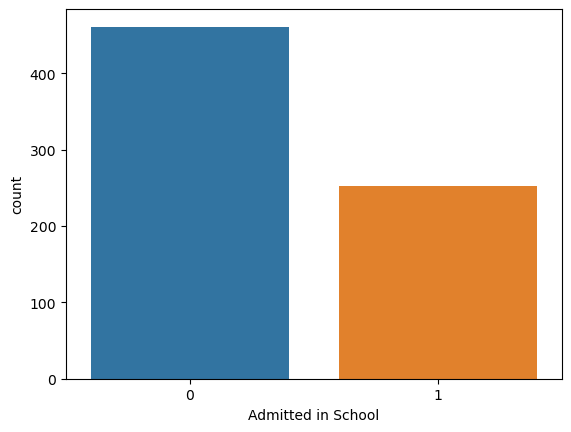

In [28]:
cat_frequency(df, 'Admitted in School')

There is an imbalance in the target variable, 64% of the observations correpond to students who weren't admitted whilst only 36% corresponds to students who were. This might be an issue as it may lead models to overclassify as 0s.

In [29]:
df.loc[df['Admitted in School'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,461.0,440.748373,259.967393,1.0,204.0000,451.0,667.0,889.0
Experience Level,350.0,30.761429,14.127168,1.0,21.0000,28.0,39.0,74.0
Student Siblings,461.0,0.537961,1.200168,0.0,0.0000,0.0,1.0,8.0
Student Family,461.0,0.314534,0.790422,0.0,0.0000,0.0,0.0,6.0
Financial Background,461.0,21.729961,30.998317,0.0,7.8958,10.5,26.0,263.0
Student Social Influence,461.0,12.605206,7.083991,1.0,6.0000,13.0,19.0,24.0
Admitted in School,461.0,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0


In [30]:
df.loc[df['Admitted in School'] == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,252.0,448.257937,252.442650,2.00,246.500,443.5,662.0000,888.0000
Experience Level,217.0,28.486959,15.258763,0.42,19.000,28.0,38.0000,80.0000
Student Siblings,252.0,0.492063,0.727885,0.00,0.000,0.0,1.0000,4.0000
Student Family,252.0,0.428571,0.729881,0.00,0.000,0.0,1.0000,3.0000
Financial Background,252.0,48.884162,71.487471,0.00,12.475,26.0,56.9469,512.3292
Student Social Influence,252.0,12.928571,6.705743,1.00,7.000,14.0,19.0000,24.0000
Admitted in School,252.0,1.000000,0.000000,1.00,1.000,1.0,1.0000,1.0000


Students who were admitted have, on average, higher financial backgrounds than those who were rejected, however the standard deviation is also a lot higher so these values aren't directly comparable. Students who were admitted also seem to have slightly lower average experience levels and slightly higher average number of family members attending the school.

In [31]:
df.loc[df['Admitted in School'] == 0].describe(include = 'object').transpose()

,count,unique,top,freq
Program,461,3,Sorcery School,304
Student Gender,461,2,male,390
School Dormitory,57,6,Cottage Chamber,20
School of Origin,461,3,Mystic Academy,357
Favourite Study Element,461,4,Fire,120


In [32]:
df.loc[df['Admitted in School'] == 1].describe(include = 'object').transpose()

,count,unique,top,freq
Program,252,3,Magi Academy,98
Student Gender,252,2,female,173
School Dormitory,96,6,Mystical Chamber,35
School of Origin,252,3,Mystic Academy,167
Favourite Study Element,252,4,Earth,65


Most of the students who weren't admitted were male whilst most students who were admitted were female, this feature might be one of the best predictors since the difference is so large. Besides that, most students who were rejected applied to sorcery school and prefered the study element earth.

## Categorical Features

### Program

,Sorcery School,Magi Academy,Witchcraft Institute
Frequency Percentage,54,23,21


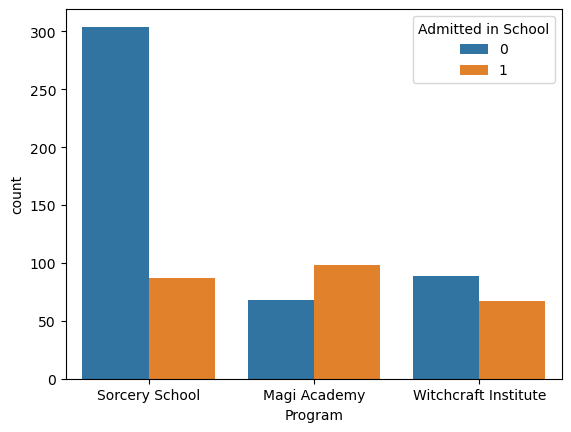

In [33]:
cat_frequency(df, 'Program', hue = 'Admitted in School')

In [34]:
percent_admitted(df, var = 'Program')

,Magi Academy Program,Sorcery School Program,Witchcraft Institute Program
Percent Admitted,59.04,22.25,42.95
Count,166.00,391.00,156.00
Total Admitted,98.00,87.00,67.00


Around the same number of students (160) applied to magi academy and witchcraft institute, but the most popular program was by far sorcery school where 391 students applied. Out of these 391 students only 87 were accepted which is around 22%, in comparison 59% of the students who applied to magi academy were accepted and 43% of those who applied to witchcraft institute were admitted. Even though less students applied to magi academy than sorcery school more students were admitted to the first than the latter.

In [35]:
df.loc[df['Program'] == 'Sorcery School'].loc[df['Admitted in School'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,304.0,442.148026,261.684732,1.0000,200.25,461.00,662.50000,889.00
Experience Level,214.0,25.831776,11.882532,1.0000,19.00,24.25,33.00000,74.00
Student Siblings,304.0,0.661184,1.409658,0.0000,0.00,0.00,1.00000,8.00
Student Family,304.0,0.371711,0.880663,0.0000,0.00,0.00,0.00000,6.00
Financial Background,304.0,13.388705,11.157406,4.0125,7.75,8.05,15.13645,69.55
Student Social Influence,304.0,12.694079,7.045948,1.0000,6.00,13.00,19.00000,24.00
Admitted in School,304.0,0.000000,0.000000,0.0000,0.00,0.00,0.00000,0.00


In [36]:
df.loc[df['Program'] == 'Sorcery School'].loc[df['Admitted in School'] == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,87.0,395.770115,261.013174,3.00,169.500,349.0000,644.50,876.0000
Experience Level,63.0,20.506667,12.503115,0.42,12.500,22.0000,27.00,63.0000
Student Siblings,87.0,0.448276,0.845764,0.00,0.000,0.0000,1.00,4.0000
Student Family,87.0,0.356322,0.681602,0.00,0.000,0.0000,0.50,3.0000
Financial Background,87.0,13.695259,10.948530,0.00,7.775,8.6833,15.85,56.4958
Student Social Influence,87.0,12.045977,7.088983,1.00,6.000,13.0000,18.00,24.0000
Admitted in School,87.0,1.000000,0.000000,1.00,1.000,1.0000,1.00,1.0000


The only significant difference between the students who were admitted to sorcery school and those who werent is that the admitted students had lower average experience levels. The middle 50% of the students admitted had experience levels between 12.5 and 27 whilst for the middle 50% who were rejected these values were between 19 and 33. The experience level variable may be useful when combined with the program to predict the target.

In [37]:
df.loc[df['Program'] == 'Magi Academy'].loc[df['Admitted in School'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,68.0,405.279412,260.208289,7.0,165.7500,437.0000,608.750000,873.0
Experience Level,53.0,45.594340,13.625858,18.0,37.0000,46.0000,55.000000,71.0
Student Siblings,68.0,0.294118,0.574556,0.0,0.0000,0.0000,0.250000,3.0
Student Family,68.0,0.279412,0.687752,0.0,0.0000,0.0000,0.000000,4.0
Financial Background,68.0,62.722056,61.026579,0.0,27.7208,41.2625,77.678125,263.0
Student Social Influence,68.0,11.867647,7.156887,1.0,5.0000,12.0000,18.250000,24.0
Admitted in School,68.0,0.000000,0.000000,0.0,0.0000,0.0000,0.000000,0.0


In [38]:
df.loc[df['Program'] == 'Magi Academy'].loc[df['Admitted in School'] == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,98.0,514.908163,233.181717,2.0000,321.50,539.50000,706.500000,888.0000
Experience Level,90.0,35.510222,14.134195,0.9200,24.25,35.00000,47.750000,80.0000
Student Siblings,98.0,0.500000,0.661925,0.0000,0.00,0.00000,1.000000,3.0000
Student Family,98.0,0.326531,0.638547,0.0000,0.00,0.00000,0.000000,2.0000
Financial Background,98.0,98.250386,94.733332,25.9292,39.45,77.34375,110.387475,512.3292
Student Social Influence,98.0,13.153061,6.766126,1.0000,7.00,14.00000,19.000000,24.0000
Admitted in School,98.0,1.000000,0.000000,1.0000,1.00,1.00000,1.000000,1.0000


Magi academy seems to have the same pattern of the admitted students having lower experience levels, however in this case the values are considerably higher than they were for sorcery school. Another difference is that whilst in sorcery school the financial background was very similiar for admitted and rejected students the same is not true for magi academy, the middle 50% of the students who were admitted had financial backgrounds between 39.45 and 110 whilst the middle 50% of the rejected students had financial backgrounds between 27 and 77. It seems that financial background might play a bigger role if a student applies to magi academy or this variable might be correlated with other desirable characteristics.

In [39]:
df.loc[df['Program'] == 'Witchcraft Institute'].loc[df['Admitted in School'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,89.0,463.067416,253.882525,34.0,235.0,419.0,696.0,887.0
Experience Level,83.0,34.000000,12.193311,16.0,25.0,31.0,39.0,70.0
Student Siblings,89.0,0.303371,0.530962,0.0,0.0,0.0,1.0,2.0
Student Family,89.0,0.146067,0.440830,0.0,0.0,0.0,0.0,2.0
Financial Background,89.0,18.901638,14.554283,0.0,11.5,13.0,26.0,73.5
Student Social Influence,89.0,12.865169,7.201943,1.0,7.0,13.0,19.0,24.0
Admitted in School,89.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [40]:
df.loc[df['Program'] == 'Witchcraft Institute'].loc[df['Admitted in School'] == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,67.0,418.925373,250.140343,10.00,203.00,433.0,599.000,881.0
Experience Level,64.0,26.466094,14.963454,0.67,18.75,28.0,35.250,55.0
Student Siblings,67.0,0.537313,0.658933,0.00,0.00,0.0,1.000,3.0
Student Family,67.0,0.671642,0.859670,0.00,0.00,0.0,1.000,3.0
Financial Background,67.0,22.369901,11.174064,10.50,13.00,23.0,26.125,65.0
Student Social Influence,67.0,13.746269,6.038621,2.00,9.50,14.0,18.000,24.0
Admitted in School,67.0,1.000000,0.000000,1.00,1.00,1.0,1.000,1.0


Students who were admitted in to withcraft institute also follow the same trend of habing lower experience levels than those rejected. The admitted students also have higher average values of financial backgrounds than those rejected however it's not as big of a difference as it was for magi academy.

### Student Gender

,male,female
Frequency Percentage,65,34


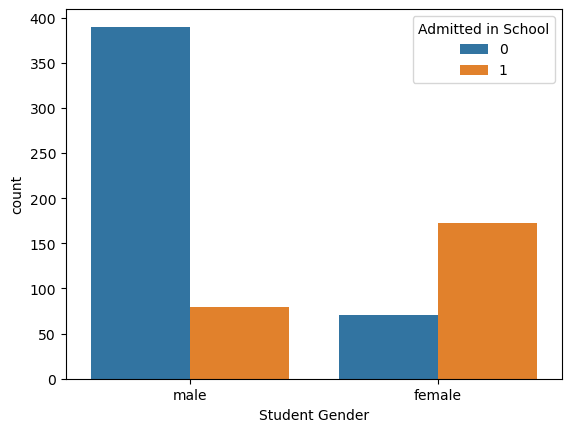

In [41]:
cat_frequency(df, 'Student Gender', hue = 'Admitted in School')

In [42]:
percent_admitted(df, 'Student Gender')

,female Student Gender,male Student Gender
Percent Admitted,70.9,16.84
Count,244.0,469.00
Total Admitted,173.0,79.00


There were a lot more male female applicants, however a lot more female students were admitted than male students (173 vs 79), which corresponds to around 71% of female students being admitted and 84% of male students being rejected.

In [43]:
df.loc[df['Student Gender'] == 'female'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,244.0,435.569672,257.169956,2.00,230.750000,425.50000,643.5000,889.0000
Experience Level,205.0,27.853659,14.419568,0.75,18.000000,27.00000,38.0000,63.0000
Student Siblings,244.0,0.774590,1.248213,0.00,0.000000,0.00000,1.0000,8.0000
Student Family,244.0,0.622951,0.967181,0.00,0.000000,0.00000,1.0000,6.0000
Financial Background,244.0,42.703417,58.570878,6.75,11.810425,21.71665,51.6094,512.3292
Student Social Influence,244.0,13.081967,6.637083,1.00,7.000000,14.00000,19.0000,24.0000
Admitted in School,244.0,0.709016,0.455150,0.00,0.000000,1.00000,1.0000,1.0000


In [44]:
df.loc[df['Student Gender'] == 'male'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,469.0,447.477612,257.366010,1.00,215.0000,463.0000,675.00,887.0000
Experience Level,362.0,31.044669,14.593982,0.42,21.0000,29.0000,39.00,80.0000
Student Siblings,469.0,0.390192,0.917069,0.00,0.0000,0.0000,0.00,8.0000
Student Family,469.0,0.215352,0.601369,0.00,0.0000,0.0000,0.00,5.0000
Financial Background,469.0,25.408714,45.367613,0.00,7.8958,11.2417,26.55,512.3292
Student Social Influence,469.0,12.530917,7.106456,1.00,6.0000,13.0000,19.00,24.0000
Admitted in School,469.0,0.168443,0.374659,0.00,0.0000,0.0000,0.00,1.0000


Female students appear to have slightly lower average experience levels however when we look at the interquatile range the values are very similiar for both genders. The bigger difference seem to come in financial background where the middle 50% of female students have financial backgrounds between 12 and 51 whilst in mal students is between 8 and 26. We also see that female students appear to have on average a higher number of student siblings and family.

In [45]:
df.loc[df['Student Gender'] == 'female'].describe(include = 'object').transpose()

,count,unique,top,freq
Program,244,3,Sorcery School,117
Student Gender,244,1,female,244
School Dormitory,69,6,Mystical Chamber,25
School of Origin,244,3,Mystic Academy,164
Favourite Study Element,244,4,Water,67


In [46]:
df.loc[df['Student Gender'] == 'male'].describe(include = 'object').transpose()

,count,unique,top,freq
Program,469,3,Sorcery School,274
Student Gender,469,1,male,469
School Dormitory,84,5,Mystical Chamber,26
School of Origin,469,3,Mystic Academy,360
Favourite Study Element,469,4,Fire,123


The only difference here is that female students prefer the study element water while male students prefer fire however based on the frequency and count these specific values corresponde to around 25%-30% so it's not very significant.

In [47]:
df.loc[df['Student Gender'] == 'male'].loc[df['Admitted in School'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,390.0,443.928205,259.184136,1.0,208.0000,457.5,674.5,887.0
Experience Level,295.0,31.967797,13.959787,1.0,22.0000,29.0,40.0,74.0
Student Siblings,390.0,0.389744,0.957663,0.0,0.0000,0.0,0.0,8.0
Student Family,390.0,0.197436,0.599480,0.0,0.0000,0.0,0.0,5.0
Financial Background,390.0,21.712220,32.498775,0.0,7.8542,9.5,26.0,263.0
Student Social Influence,390.0,12.538462,7.141415,1.0,6.0000,13.0,19.0,24.0
Admitted in School,390.0,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0


In [48]:
df.loc[df['Student Gender'] == 'male'].loc[df['Admitted in School'] == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,79.0,465.000000,249.055755,18.00,265.00000,508.0000,677.00,858.0000
Experience Level,67.0,26.980149,16.622203,0.42,17.50000,28.0000,36.00,80.0000
Student Siblings,79.0,0.392405,0.687204,0.00,0.00000,0.0000,1.00,4.0000
Student Family,79.0,0.303797,0.606681,0.00,0.00000,0.0000,0.00,2.0000
Financial Background,79.0,43.657228,81.709318,0.00,9.08125,26.2875,37.25,512.3292
Student Social Influence,79.0,12.493671,6.975917,1.00,6.00000,14.0000,17.50,24.0000
Admitted in School,79.0,1.000000,0.000000,1.00,1.00000,1.0000,1.00,1.0000


Male students who were accepted had on average higher financial backgrounds than those rejected, they also had lower average experience levels and higher numbers of family members already attending the school.

In [49]:
df.loc[df['Student Gender'] == 'female'].loc[df['Admitted in School'] == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,71.0,423.281690,265.409935,15.00,190.50000,420.0000,639.00,889.00
Experience Level,55.0,24.290909,13.351963,2.00,15.25000,24.0000,30.75,57.00
Student Siblings,71.0,1.352113,1.890568,0.00,0.00000,1.0000,1.50,8.00
Student Family,71.0,0.957746,1.269833,0.00,0.00000,0.0000,2.00,6.00
Financial Background,71.0,21.827408,21.098728,6.75,9.53125,15.2458,26.00,151.55
Student Social Influence,71.0,12.971831,6.796999,1.00,7.00000,13.0000,19.00,24.00
Admitted in School,71.0,0.000000,0.000000,0.00,0.00000,0.0000,0.00,0.00


In [50]:
df.loc[df['Student Gender'] == 'female'].loc[df['Admitted in School'] == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,173.0,440.612717,254.323670,2.000,242.0,428.0,645.0000,888.0000
Experience Level,150.0,29.160000,14.617158,0.750,19.5,28.5,39.0000,63.0000
Student Siblings,173.0,0.537572,0.743209,0.000,0.0,0.0,1.0000,4.0000
Student Family,173.0,0.485549,0.774649,0.000,0.0,0.0,1.0000,3.0000
Financial Background,173.0,51.271027,66.421003,7.225,13.0,26.0,71.2833,512.3292
Student Social Influence,173.0,13.127168,6.589810,1.000,7.0,14.0,19.0000,24.0000
Admitted in School,173.0,1.000000,0.000000,1.000,1.0,1.0,1.0000,1.0000


The female students who were admitted had higher experience levels than those rejected which doesn't follow the trend we have been observing so it's possible that student gender is more important than experience level. They also had considerably higher levels of financial background than the female students who weren't accepted.

### School of Origin

,Mystic Academy,Eldertree Enclave,Arcan Institute
Frequency Percentage,73,18,7


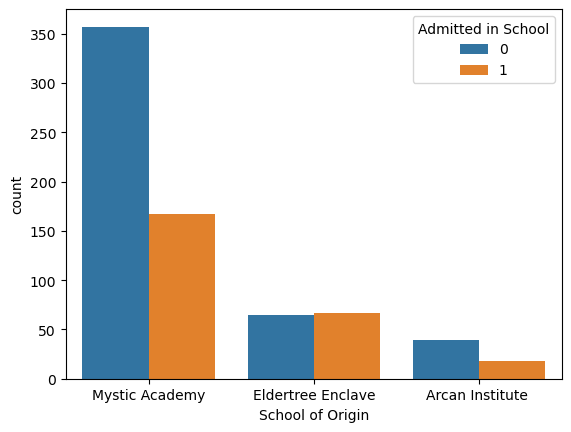

In [51]:
cat_frequency(df, 'School of Origin', hue = 'Admitted in School')

In [52]:
percent_admitted(df, 'School of Origin')

,Arcan Institute School of Origin,Eldertree Enclave School of Origin,Mystic Academy School of Origin
Percent Admitted,31.58,50.76,31.87
Count,57.00,132.00,524.00
Total Admitted,18.00,67.00,167.00


Almost 3/4 of the students came from mystic academy, 18% came from eldertree enclave and only 7% came from arcan institute. We can also see that 1/2 the students who came from eldertree enclave were admitted, for the other two schools of origin this value is around the same at 32%.

In [53]:
df.loc[df['School of Origin'] == 'Eldertree Enclave'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,132.0,437.643939,263.421676,2.0000,213.000000,451.5000,660.500000,880.0000
Experience Level,100.0,31.019200,16.109858,0.4200,20.750000,30.0000,40.000000,71.0000
Student Siblings,132.0,0.393939,0.562947,0.0000,0.000000,0.0000,1.000000,2.0000
Student Family,132.0,0.318182,0.621721,0.0000,0.000000,0.0000,0.000000,3.0000
Financial Background,132.0,57.880086,88.166864,4.0125,11.810425,27.7208,76.401075,512.3292
Student Social Influence,132.0,14.628788,6.711509,1.0000,9.000000,16.0000,20.250000,24.0000
Admitted in School,132.0,0.507576,0.501847,0.0000,0.000000,1.0000,1.000000,1.0000


In [54]:
df.loc[df['School of Origin'] != 'Eldertree Enclave'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,581.0,444.710843,255.954432,1.00,221.0000,443.0,667.0000,889.0
Experience Level,467.0,29.649358,14.262165,0.67,20.7500,28.0,39.0000,80.0
Student Siblings,581.0,0.550775,1.138475,0.00,0.0000,0.0,1.0000,8.0
Student Family,581.0,0.363167,0.801262,0.00,0.0000,0.0,0.0000,6.0
Financial Background,581.0,25.294577,35.045545,0.00,7.8958,13.0,26.2875,263.0
Student Social Influence,581.0,12.285714,6.935239,1.00,6.0000,13.0,18.0000,24.0
Admitted in School,581.0,0.318417,0.466263,0.00,0.0000,0.0,1.0000,1.0


The middle 50% of students from eldertree enclave had a financial background betweem 12 and 76 whilst for the other two schools the middle 50% of students had financial backgrounds ranging from 8 to 26, this is a very big difference and as we've seen it might have had an influence on students from this school of origin being more admitted than those from other schools. Besides this feature the other values are very similiar.

In [55]:
df.loc[df['School of Origin'] == 'Eldertree Enclave'].describe(include = 'object').transpose()

,count,unique,top,freq
Program,132,3,Magi Academy,63
Student Gender,132,2,male,76
School Dormitory,49,5,Cottage Chamber,15
School of Origin,132,1,Eldertree Enclave,132
Favourite Study Element,132,4,Air,40


In [56]:
df.loc[df['School of Origin'] != 'Eldertree Enclave'].describe(include = 'object').transpose()

,count,unique,top,freq
Program,581,3,Sorcery School,337
Student Gender,581,2,male,393
School Dormitory,104,6,Mystical Chamber,36
School of Origin,581,2,Mystic Academy,524
Favourite Study Element,581,4,Earth,150


Another key difference is that even though the most popular program was sorcery school around 1/2 of the students from eldertree enclave applied to magi academy, this can also be related half of them being accepted.

### Favourite Study Element

,Earth,Air,Fire,Water
Frequency Percentage,25,25,25,23


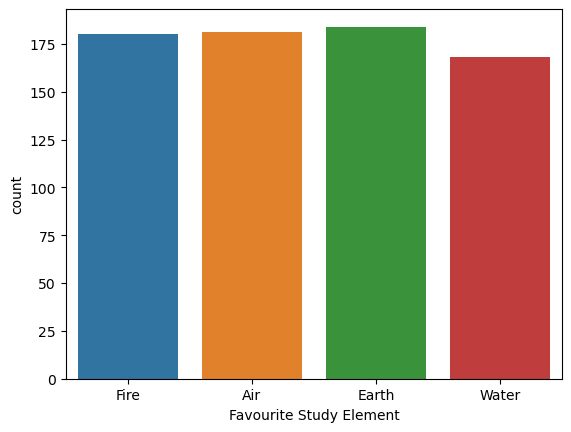

In [57]:
cat_frequency(df, 'Favourite Study Element')

In [58]:
percent_admitted(df, 'Favourite Study Element')

,Air Favourite Study Element,Earth Favourite Study Element,Fire Favourite Study Element,Water Favourite Study Element
Percent Admitted,34.25,35.33,33.33,38.69
Count,181.00,184.00,180.00,168.00
Total Admitted,62.00,65.00,60.00,65.00


Favourite study element doesn't seem to have much of an influence in a student being admitted or not. The distribution is near identical with slighly less students prefering the favourite study element water.

## Numerical Features

,0 Student Siblings,1 Student Siblings,2 Student Siblings,3 Student Siblings,4 Student Siblings,5 Student Siblings,8 Student Siblings
Percent Admitted,31.74,48.24,45.83,26.67,15.38,0.0,0.0
Count,482.00,170.00,24.00,15.00,13.00,5.0,4.0
Total Admitted,153.00,82.00,11.00,4.00,2.00,0.0,0.0


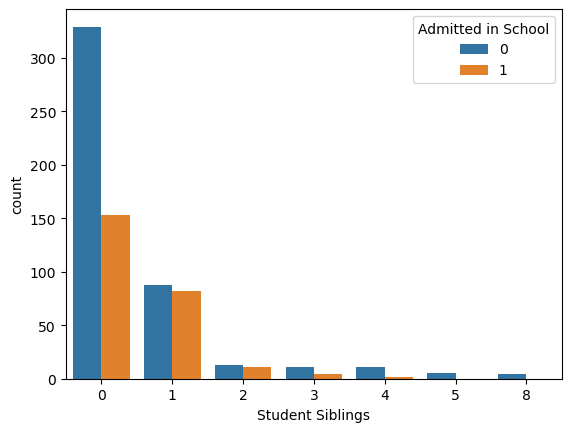

In [59]:
sns.countplot(data = df, x = 'Student Siblings', hue = 'Admitted in School');
percent_admitted(df, 'Student Siblings')

No student with more than 4 siblings was accepted. There was a lot more students with 0 siblings than any other value and students with 1 or 2 siblings had the highest relative admission rate. Out of the 37 students with 3 or more siblings only 6 of them were admitted.

In [60]:
df.loc[df['Student Siblings'] <= 2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,676.0,448.542899,255.817637,1.00,225.7500,454.5,668.5000,889.0000
Experience Level,538.0,30.942695,14.111169,0.42,22.0000,29.0,39.7500,80.0000
Student Siblings,676.0,0.322485,0.538445,0.00,0.0000,0.0,1.0000,2.0000
Student Family,676.0,0.291420,0.727848,0.00,0.0000,0.0,0.0000,6.0000
Financial Background,676.0,30.051744,49.808155,0.00,7.8958,13.0,27.7208,512.3292
Student Social Influence,676.0,12.733728,6.927569,1.00,7.0000,13.0,19.0000,24.0000
Admitted in School,676.0,0.363905,0.481478,0.00,0.0000,0.0,1.0000,1.0000


In [61]:
df.loc[df['Student Siblings'] > 2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,37.0,349.486486,267.443205,8.00,120.0,267.000,543.0,864.0
Experience Level,29.0,10.379310,8.599891,1.00,4.0,8.000,14.0,33.0
Student Siblings,37.0,4.162162,1.518653,3.00,3.0,4.000,4.0,8.0
Student Family,37.0,1.513514,0.606521,0.00,1.0,2.000,2.0,2.0
Financial Background,37.0,54.630859,64.357593,15.85,27.9,31.275,46.9,263.0
Student Social Influence,37.0,12.459459,7.437124,1.00,6.0,15.000,19.0,24.0
Admitted in School,37.0,0.162162,0.373684,0.00,0.0,0.000,0.0,1.0


The middle 50% of students with 3 or more siblings have financial backgrounds between 28 and 47 which is considerably higher then the middle 50% for those with 2 or less siblings which fall in the range of 8 to 27. Students with 3 or more siblings also have a considerably lower middle range of experience level, 4 to 14 compared to 22 to 39.75 for those with 2 or less siblings. Base on what we have been seeing these should've been good characteristics and yet only 16% of these students were admitted. It's likely that having a lot of siblings is not a good characteristic and it may negatively influence a student's chances of being accepted.

In [62]:
df.loc[df['Student Siblings'] >= 3].loc[df['Admitted in School'] == 1]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
70,86,Sorcery School,female,33.0,3,0,15.8500,NaN,Mystic Academy,15,Earth,1
72,89,Magi Academy,female,23.0,3,2,263.0000,Cottage Chamber,Mystic Academy,21,Air,1
191,234,Sorcery School,female,5.0,4,2,31.3875,NaN,Mystic Academy,1,Fire,1
217,262,Sorcery School,male,3.0,4,2,31.3875,NaN,Mystic Academy,6,Fire,1
276,342,Magi Academy,female,24.0,3,2,263.0000,Cottage Chamber,Mystic Academy,20,Air,1
587,727,Witchcraft Institute,female,30.0,3,0,21.0000,NaN,Mystic Academy,10,Water,1


The only students admitted with 3 or more siblings were either female or a single male student with a very low experience level and an average financial background.

In [63]:
df.loc[df['Student Siblings'] == 8]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
131,160,Sorcery School,male,NaN,8,2,69.55,NaN,Mystic Academy,2,Fire,0
148,181,Sorcery School,female,NaN,8,2,69.55,NaN,Mystic Academy,17,Earth,0
638,793,Sorcery School,female,NaN,8,2,69.55,NaN,Mystic Academy,2,Air,0
695,864,Sorcery School,female,NaN,8,2,69.55,NaN,Mystic Academy,18,Water,0


The students who had 8 siblings appear to be from the same family as they have exactly the same financial background and school or origin, they are also all missing experience level. I'm not going to remove these rows since they add signal that a high number of siblings is not desirable.

### Student Family

,0 Student Family,1 Student Family,2 Student Family,3 Student Family,4 Student Family,5 Student Family,6 Student Family
Percent Admitted,32.07,49.45,45.76,75.0,0.0,0.0,0.0
Count,552.00,91.00,59.00,4.0,4.0,2.0,1.0
Total Admitted,177.00,45.00,27.00,3.0,0.0,0.0,0.0


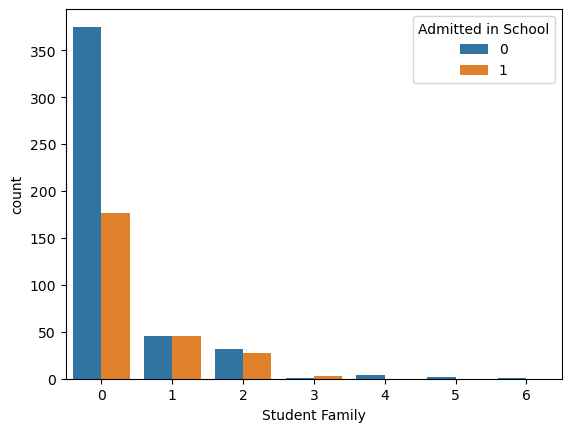

In [64]:
sns.countplot(data = df, x = 'Student Family', hue = 'Admitted in School');
percent_admitted(df, 'Student Family')

Around 1/2 of students with 1 or 2 family members already attending were accepted and no student with 4 or more was admitted, the distribution of this feature is quite similiar to student siblings both in terms of count and relative percentage of students admitted with the exception of those with 3 family member already attending where 3 out of 4 students were accepted.

In [65]:
df.loc[df['Student Family'] <= 3].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,706.0,443.776204,257.447037,1.00,219.250,447.50000,666.75,889.0000
Experience Level,560.0,29.730661,14.577512,0.42,20.000,28.00000,38.25,80.0000
Student Siblings,706.0,0.518414,1.061419,0.00,0.000,0.00000,1.00,8.0000
Student Family,706.0,0.313031,0.645574,0.00,0.000,0.00000,0.00,3.0000
Financial Background,706.0,31.001410,50.399233,0.00,7.925,13.93125,29.70,512.3292
Student Social Influence,706.0,12.689802,6.946918,1.00,7.000,13.00000,19.00,24.0000
Admitted in School,706.0,0.356941,0.479437,0.00,0.000,0.00000,1.00,1.0000


In [66]:
df.loc[df['Student Family'] > 3].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,7.0,405.714286,243.659403,14.000,264.5,439.000,589.5000,679.0
Experience Level,7.0,42.714286,10.656990,29.000,39.0,40.000,44.0000,64.0
Student Siblings,7.0,0.857143,0.377964,0.000,1.0,1.000,1.0000,1.0
Student Family,7.0,4.571429,0.786796,4.000,4.0,4.000,5.0000,6.0
Financial Background,7.0,64.189286,88.018924,21.075,27.9,31.275,39.0875,263.0
Student Social Influence,7.0,15.714286,7.087884,2.000,14.0,16.000,20.5000,23.0
Admitted in School,7.0,0.000000,0.000000,0.000,0.0,0.000,0.0000,0.0


The middle 50% of the students with 4 or more siblings had financial backgrounds between 28 and 39, those with 3 or less had this feature ranging from 8 to 29 which is considerably lower. These students did however appear to have a lot higher experience level than students with less family members attending. It seems that a high number of family members attending might be related to a higher experience level which may come in handy when filling the missing values for the variable.

In [67]:
df.loc[df['Student Family'] <= 3].describe(include = 'object').transpose()

,count,unique,top,freq
Program,706,3,Sorcery School,385
Student Gender,706,2,male,466
School Dormitory,152,6,Mystical Chamber,51
School of Origin,706,3,Mystic Academy,517
Favourite Study Element,706,4,Earth,183


In [68]:
df.loc[df['Student Family'] > 3].describe(include = 'object').transpose()

,count,unique,top,freq
Program,7,2,Sorcery School,6
Student Gender,7,2,female,4
School Dormitory,1,1,Cottage Chamber,1
School of Origin,7,1,Mystic Academy,7
Favourite Study Element,7,4,Water,3


4 out of the 7 students with 4 or more family members attending were female which were a lot more accepted than male students, yet in this case none of them was accepted. It's likely that after a certain number of student family attending it becomes harder or impossible to get in. This feature seems to be a good variable to use.

### Student Social Influence

C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


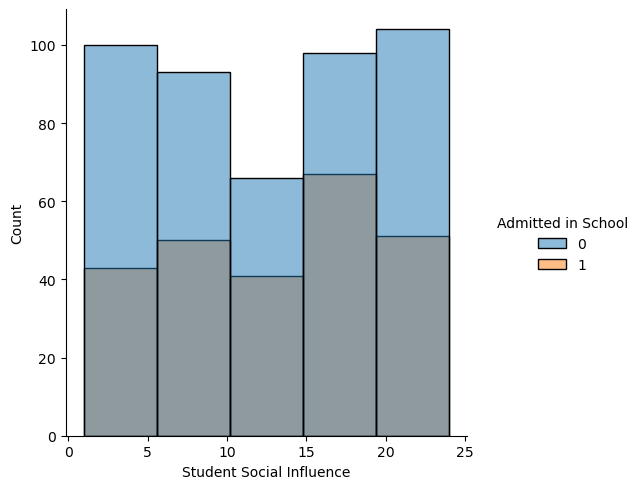

In [69]:
sns.displot(data = df, x = 'Student Social Influence', hue = 'Admitted in School', bins = 5);

Student Social Influence doesn't appear to have any influence on the target variable.

C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


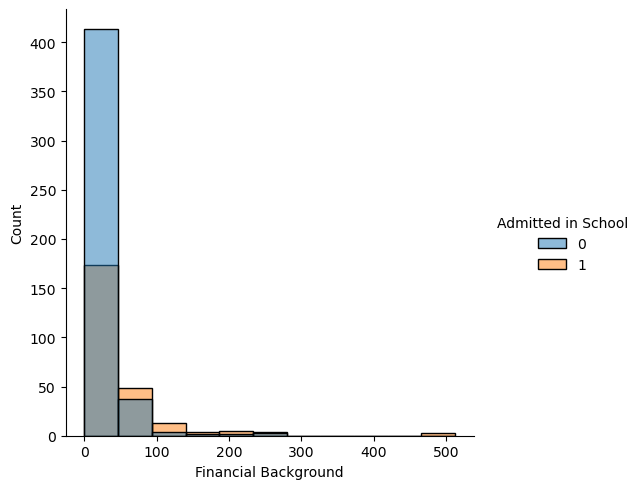

In [70]:
sns.displot(data = df, x = 'Financial Background', hue = 'Admitted in School', bins = sturges_bins(df));

In [71]:
iqr_outliers(df, 'Financial Background', sens = 3)

For the variable Financial Background any value below -58.3 or above 96.225 is considered a outlier


Financial background has a very skewed distribution. Using the interquartile range method of identifying sever outliers we can easily see that we have a couple of them as any student with a financial background higher than 96.225 is considered an outlier. The relative percentage of students admitted based on their range of financial background also seems to increase as the financial background increases.

In [72]:
admitted_correlation(df, 'Financial Background')

39% of the students above the 0.2 percentile were admitted
41% of the students above the 0.3 percentile were admitted
46% of the students above the 0.4 percentile were admitted
48% of the students above the 0.5 percentile were admitted
50% of the students above the 0.6 percentile were admitted
52% of the students above the 0.7 percentile were admitted
59% of the students above the 0.8 percentile were admitted
71% of the students above the 0.9 percentile were admitted
72% of the students above the 0.95 percentile were admitted
75% of the students above the 0.99 percentile were admitted


0.9634049621068641

The relative percentage of students who are accepted starts growing as the percentile of financial background get's closer to the top. This is likely to be a good feature to use in order to predict a student chances of being admitted, however it doesn't seem to separate the data as well as experience level or student gender.

In [73]:
df.loc[df['Financial Background'] > 96].loc[df['Admitted in School'] == 0]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
21,28,Magi Academy,male,19.0,3,2,263.0000,Cottage Chamber,Mystic Academy,5,Fire,0
96,119,Magi Academy,male,24.0,0,1,247.5208,Mystical Chamber,Eldertree Enclave,24,Fire,0
269,333,Magi Academy,male,38.0,0,1,153.4625,Cottage Chamber,Mystic Academy,1,Fire,0
351,439,Magi Academy,male,64.0,1,4,263.0000,Cottage Chamber,Mystic Academy,23,Fire,0
397,499,Magi Academy,female,25.0,1,2,151.5500,Cottage Chamber,Mystic Academy,12,Earth,0
403,506,Magi Academy,male,18.0,1,0,108.9000,Cottage Chamber,Eldertree Enclave,9,Water,0
420,528,Magi Academy,male,NaN,0,0,221.7792,Cottage Chamber,Mystic Academy,20,Earth,0
434,545,Magi Academy,male,50.0,1,0,106.4250,Cottage Chamber,Eldertree Enclave,5,Earth,0
443,558,Magi Academy,male,NaN,0,0,227.5250,NaN,Eldertree Enclave,6,Earth,0
528,660,Magi Academy,male,58.0,0,2,113.2750,Dragon Room,Eldertree Enclave,21,Air,0


Most of the students considered to be severe outliers by the interquartile range method were male. However there was a female student who appears to have good features which was rejected.

In [74]:
df.loc[df['Financial Background'] > 96].loc[df['Admitted in School'] == 0].loc[df['Student Gender'] == 'female']

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
397,499,Magi Academy,female,25.0,1,2,151.55,Cottage Chamber,Mystic Academy,12,Earth,0


In [75]:
df.loc[df['Student Gender'] == 'female'].loc[df['Admitted in School'] == 1].loc[df['Program'] == 'Magi Academy'].loc[df['School of Origin'] == 'Mystic Academy'].loc[(df['Experience Level'] > 20) & (df['Experience Level'] < 30)]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
72,89,Magi Academy,female,23.0,3,2,263.0000,Cottage Chamber,Mystic Academy,21,Air,1
125,152,Magi Academy,female,22.0,1,0,66.6000,Cottage Chamber,Mystic Academy,24,Fire,1
239,291,Magi Academy,female,26.0,0,0,78.8500,NaN,Mystic Academy,23,Water,1
276,342,Magi Academy,female,24.0,3,2,263.0000,Cottage Chamber,Mystic Academy,20,Air,1
287,357,Magi Academy,female,22.0,0,1,55.0000,Mystical Chamber,Mystic Academy,7,Air,1
502,628,Magi Academy,female,21.0,0,0,77.9583,Dragon Room,Mystic Academy,19,Air,1
574,709,Magi Academy,female,22.0,0,0,151.5500,NaN,Mystic Academy,5,Air,1
590,731,Magi Academy,female,29.0,0,0,211.3375,Mystical Chamber,Mystic Academy,3,Water,1


Comparing the cell above with the female student in question it doesn't make sense that she was rejected when we have students that were very similiar to her that were rejected.

In [76]:
df = df.drop(397)

In [77]:
df.loc[df['Financial Background'] > 96].loc[df['Admitted in School'] == 0].loc[df['Experience Level'] <= 50].loc[df['Student Siblings'] <= 3]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
21,28,Magi Academy,male,19.0,3,2,263.0000,Cottage Chamber,Mystic Academy,5,Fire,0
96,119,Magi Academy,male,24.0,0,1,247.5208,Mystical Chamber,Eldertree Enclave,24,Fire,0
269,333,Magi Academy,male,38.0,0,1,153.4625,Cottage Chamber,Mystic Academy,1,Fire,0
403,506,Magi Academy,male,18.0,1,0,108.9000,Cottage Chamber,Eldertree Enclave,9,Water,0
434,545,Magi Academy,male,50.0,1,0,106.4250,Cottage Chamber,Eldertree Enclave,5,Earth,0
565,699,Magi Academy,male,49.0,1,1,110.8833,Cottage Chamber,Eldertree Enclave,22,Earth,0


In [78]:
df.loc[df['Financial Background'] > 96].loc[df['Admitted in School'] == 1].loc[df['Student Gender'] == 'male']

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
251,306,Magi Academy,male,0.92,1,2,151.5500,Cottage Chamber,Mystic Academy,15,Air,1
529,661,Magi Academy,male,50.00,2,0,133.6500,NaN,Mystic Academy,9,Air,1
546,680,Magi Academy,male,36.00,0,1,512.3292,Mystical Chamber,Eldertree Enclave,6,Earth,1
595,738,Magi Academy,male,35.00,0,0,512.3292,Mystical Chamber,Eldertree Enclave,15,Water,1
646,803,Magi Academy,male,11.00,1,2,120.0000,Mystical Chamber,Mystic Academy,10,Air,1


Comparing the two cells above it doesn't appear to be any reason to why the outlier students in the financial background were all rejected. There are very similiar students who were all accepted. This type of ambiguity is not good for models and therefore i'll also remove these rows.

In [79]:
df = df.drop([96, 269, 403, 434, 565])

In [80]:
df.loc[df['Financial Background'] > 500]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
214,259,Magi Academy,female,35.0,0,0,512.3292,NaN,Eldertree Enclave,15,Air,1
546,680,Magi Academy,male,36.0,0,1,512.3292,Mystical Chamber,Eldertree Enclave,6,Earth,1
595,738,Magi Academy,male,35.0,0,0,512.3292,Mystical Chamber,Eldertree Enclave,15,Water,1


These 3 students are very similiar and are also the most extreme outliers in the financial background feature, however besides being extreme in this feature they appear to follow the same trends that we've been observing throughout the analysis process. They seem to just come from a very wealthy background and to most of the models we'll use this shouldn't be an issue.

### Features with missing data

##### School Dormitory

School Dormitory has around 75% of it's data missing. Based on the project handout this feature doesn't seem to be important but we should verify this before removing it.

In [81]:
dorm_miss = df.loc[df['School Dormitory'].isna()]
dorm_pres = df.loc[df['School Dormitory'].notna()]

In [82]:
dorm_miss.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,560.0,439.455357,257.914669,1.00,212.7500,437.5000,661.25,889.0000
Experience Level,427.0,27.615340,13.482879,0.42,19.0000,26.0000,35.00,74.0000
Student Siblings,560.0,0.541071,1.143587,0.00,0.0000,0.0000,1.00,8.0000
Student Family,560.0,0.342857,0.786937,0.00,0.0000,0.0000,0.00,6.0000
Financial Background,560.0,19.241428,30.082065,0.00,7.8958,11.1333,23.00,512.3292
Student Social Influence,560.0,12.669643,7.008796,1.00,6.0000,13.0000,19.00,24.0000
Admitted in School,560.0,0.278571,0.448697,0.00,0.0000,0.0000,1.00,1.0000


In [83]:
dorm_pres.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,147.0,458.163265,257.323315,2.00,252.50,474.0,690.500,888.0000
Experience Level,134.0,36.958358,15.812645,0.92,27.00,36.0,48.750,80.0000
Student Siblings,147.0,0.442177,0.653015,0.00,0.00,0.0,1.000,3.0000
Student Family,147.0,0.380952,0.705491,0.00,0.00,0.0,1.000,4.0000
Financial Background,147.0,72.669248,79.030064,0.00,26.55,52.0,83.475,512.3292
Student Social Influence,147.0,12.931973,6.669969,1.00,7.50,13.0,19.000,24.0000
Admitted in School,147.0,0.653061,0.477623,0.00,0.00,1.0,1.000,1.0000


Students who have the school dormitory data had higher levels of experience and financial backgrounds on average. They were also more admitted than those who didn't have the data.

In [84]:
df.loc[df['School Dormitory'] == 'Grand Chambers']['Program'].value_counts()

Program
Sorcery School    4
Name: count, dtype: int64

In [85]:
df.loc[df['School Dormitory'] == 'Python Quarters']['Program'].value_counts()

Program
Witchcraft Institute    6
Sorcery School          4
Name: count, dtype: int64

In [86]:
df.loc[df['School Dormitory'] == 'Tangerine Rooms']['Program'].value_counts()

Program
Magi Academy    15
Name: count, dtype: int64

In [87]:
df.loc[df['School Dormitory'] == 'Dragon Room']['Program'].value_counts()

Program
Magi Academy            23
Witchcraft Institute     4
Name: count, dtype: int64

In [88]:
df.loc[df['School Dormitory'] == 'Cottage Chamber']['Program'].value_counts()

Program
Magi Academy    41
Name: count, dtype: int64

In [89]:
df.loc[df['School Dormitory'] == 'Mystical Chamber']['Program'].value_counts()

Program
Magi Academy            46
Witchcraft Institute     3
Sorcery School           1
Name: count, dtype: int64

Most of the dormitories only have students who applied to magi academy which is strange since the most popular program was by far sorcery school. It doesn't seem like there is a connection that always holds between the dormitory and the program a student applies to which seems to contradict what was said in the project handout. If i can prove that school dormitory doesn't have an influence on the target variable i'll simply drop this column.

In [90]:
df.loc[df['School Dormitory'].notna()].loc[df['Program'] == 'Magi Academy'].loc[df['Student Gender'] == 'female'].loc[(df['Experience Level'] >= 35) & (df['Experience Level'] <= 54)].loc[df['Financial Background'] >= 52].loc[df['Student Social Influence'] >= 6].loc[df['School of Origin'] == 'Mystic Academy'].loc[df['Student Siblings'] == 1]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
189,231,Magi Academy,female,35.0,1,0,83.4750,Cottage Chamber,Mystic Academy,20,Water,1
387,487,Magi Academy,female,35.0,1,0,90.0000,Cottage Chamber,Mystic Academy,8,Earth,1
458,578,Magi Academy,female,39.0,1,0,55.9000,Mystical Chamber,Mystic Academy,11,Air,1
616,766,Magi Academy,female,51.0,1,0,77.9583,Dragon Room,Mystic Academy,19,Water,1
662,821,Magi Academy,female,52.0,1,1,93.5000,Mystical Chamber,Mystic Academy,8,Water,1
700,872,Magi Academy,female,47.0,1,1,52.5542,Dragon Room,Mystic Academy,16,Air,1


In [91]:
df.loc[df['School Dormitory'].isna()].loc[df['Program'] == 'Magi Academy'].loc[df['Student Gender'] == 'female'].loc[df['Experience Level'] >= 35].loc[df['School of Origin'] == 'Mystic Academy']

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School Dormitory,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
305,384,Magi Academy,female,35.0,1,0,52.0000,NaN,Mystic Academy,14,Water,1
688,857,Magi Academy,female,45.0,1,1,164.8667,NaN,Mystic Academy,6,Water,1


The rows on the 2 cells above are very similiar besides the first group having the school dormitory data present and the second not. I'll drop this column since it doesn't appear to be relevant at all and it has so much missing data.

In [92]:
df = df.drop('School Dormitory', axis = 1)

#### Experience Level

Experience level has around 20% of the data missing and as we've seen it seems that it has some relationship with the program a student applies to and the number of family members already attending.

In [93]:
df.loc[df['Experience Level'].isna()].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,146.0,444.630137,250.379023,6.0,237.25,466.00,643.00,889.000
Experience Level,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Student Siblings,146.0,0.479452,1.415282,0.0,0.00,0.00,0.00,8.000
Student Family,146.0,0.150685,0.489087,0.0,0.00,0.00,0.00,2.000
Financial Background,146.0,20.273800,30.396892,0.0,7.75,8.05,23.25,227.525
Student Social Influence,146.0,12.753425,7.216420,1.0,6.00,12.50,19.00,24.000
Admitted in School,146.0,0.239726,0.428386,0.0,0.00,0.00,0.00,1.000


In [94]:
df.loc[df['Experience Level'].notna()].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,561.0,443.010695,259.816370,1.00,216.00,439.0,676.0000,888.0000
Experience Level,561.0,29.847005,14.614092,0.42,20.50,28.0,39.0000,80.0000
Student Siblings,561.0,0.531194,0.948405,0.00,0.00,0.0,1.0000,5.0000
Student Family,561.0,0.402852,0.820448,0.00,0.00,0.0,1.0000,6.0000
Financial Background,561.0,32.972556,53.409596,0.00,8.05,14.5,30.6958,512.3292
Student Social Influence,561.0,12.716578,6.867618,1.00,7.00,13.0,19.0000,24.0000
Admitted in School,561.0,0.386809,0.487454,0.00,0.00,0.0,1.0000,1.0000


On average students who aren't missing the data have higher financial backgrounds than those who don't have experience level data. Student's who don't have the data also appear to have lower numbers of student family.

In [95]:
df.loc[df['Experience Level'].isna()].describe(include = 'object').transpose()

,count,unique,top,freq
Program,146,3,Sorcery School,114
Student Gender,146,2,male,107
School of Origin,146,3,Mystic Academy,74
Favourite Study Element,146,4,Fire,46


In [96]:
df.loc[df['Experience Level'].notna()].describe(include = 'object').transpose()

,count,unique,top,freq
Program,561,3,Sorcery School,277
Student Gender,561,2,male,357
School of Origin,561,3,Mystic Academy,448
Favourite Study Element,561,4,Air,148


C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


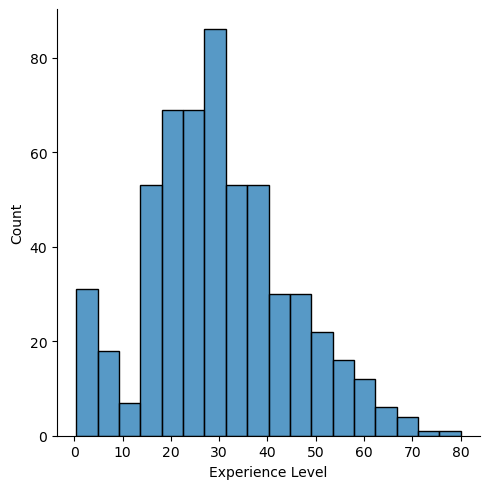

In [97]:
sns.displot(data = df, x = 'Experience Level');

In [98]:
iqr_outliers(df, 'Experience Level')

For the variable Experience Level any value below -7.25 or above 66.75 is considered a outlier


Experience level has a distibution similiar to the normal distibution so filling the missing values with the mean would probably not be a bad idea. We also see however that students with more than 66.75 experience level are considered outliers by the interquartile range. 

In [99]:
df.loc[df['Experience Level'] >= 66.75]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
79,97,Magi Academy,male,71.0,0,0,34.6542,Eldertree Enclave,13,Air,0
393,494,Magi Academy,male,71.0,0,0,49.5042,Eldertree Enclave,17,Earth,0
504,631,Magi Academy,male,80.0,0,0,30.0000,Mystic Academy,16,Air,1
539,673,Witchcraft Institute,male,70.0,0,0,10.5000,Mystic Academy,22,Air,0
602,746,Magi Academy,male,70.0,1,1,71.0000,Mystic Academy,16,Air,0
684,852,Sorcery School,male,74.0,0,0,7.7750,Mystic Academy,20,Fire,0


In the rows above the only strange observation is the student with 80 experience level who got accepted. This student is male and has an average financial background. Based on what we've been seeing it doesn't make much sense that thise student was admitted.

In [100]:
df.loc[df['Admitted in School'] == 0].loc[df['Student Gender'] == 'male'].loc[df['Program'] == 'Magi Academy'].loc[df['School of Origin'] == 'Mystic Academy'].loc[df['Student Siblings'] == 0].loc[df['Student Family'] == 0].loc[df['Student Social Influence'] > 12].loc[df['Experience Level'] > 46]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
5,7,Magi Academy,male,54.0,0,0,51.8625,Mystic Academy,13,Air,0
90,111,Magi Academy,male,47.0,0,0,52.0000,Mystic Academy,13,Air,0
208,253,Magi Academy,male,62.0,0,0,26.5500,Mystic Academy,18,Air,0
531,663,Magi Academy,male,47.0,0,0,25.5875,Mystic Academy,20,Fire,0


In [101]:
df.loc[df['Admitted in School'] == 1].loc[df['Student Gender'] == 'male'].loc[df['Program'] == 'Magi Academy'].loc[df['School of Origin'] == 'Mystic Academy'].loc[df['Student Siblings'] == 0].loc[df['Student Family'] == 0].loc[df['Experience Level'] > 46]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
358,450,Magi Academy,male,52.0,0,0,30.50,Mystic Academy,17,Earth,1
504,631,Magi Academy,male,80.0,0,0,30.00,Mystic Academy,16,Air,1
689,858,Magi Academy,male,51.0,0,0,26.55,Mystic Academy,13,Fire,1


In [102]:
df.loc[df['Student ID'] == 631]

,Student ID,Program,Student Gender,Experience Level,Student Siblings,Student Family,Financial Background,School of Origin,Student Social Influence,Favourite Study Element,Admitted in School
504,631,Magi Academy,male,80.0,0,0,30.0,Mystic Academy,16,Air,1


In the cells above we can see that students with similiar characteristics to the student who has 80 experience level were not admitted very often and the ones who were all had considerably lower experience levels at around 52 it doesn't make much sense that this particular students was admitted or at least there's nothing in the data that can explain it, therefore i'll remove this student.

In [103]:
df = df.loc[df['Student ID'] != 631]

C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


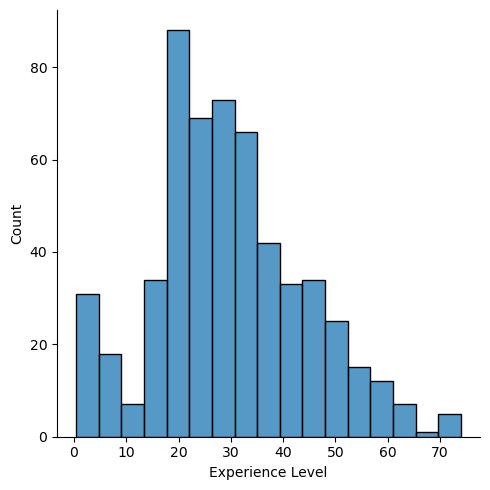

In [104]:
sns.displot(data = df, x = 'Experience Level');

As it was mentioned above it seems like Experience Level as a relationship with the program applies to and the number of family attending.

In [105]:
df.loc[df['Program'] == 'Sorcery School'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,391.0,431.828645,261.914037,1.00,193.50,426.00,656.0,889.00
Experience Level,277.0,24.620650,12.209960,0.42,18.00,24.00,31.0,74.00
Student Siblings,391.0,0.613811,1.307459,0.00,0.00,0.00,1.0,8.00
Student Family,391.0,0.368286,0.839668,0.00,0.00,0.00,0.0,6.00
Financial Background,391.0,13.456915,11.098045,0.00,7.75,8.05,15.5,69.55
Student Social Influence,391.0,12.549872,7.051601,1.00,6.00,13.00,19.0,24.00
Admitted in School,391.0,0.222506,0.416462,0.00,0.00,0.00,0.0,1.00


In [106]:
df.loc[df['Program'] == 'Witchcraft Institute'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,156.0,444.108974,252.424005,10.00,228.5,430.50000,671.5,887.0
Experience Level,147.0,30.719932,13.934432,0.67,23.5,30.00000,38.5,70.0
Student Siblings,156.0,0.403846,0.598696,0.00,0.0,0.00000,1.0,3.0
Student Family,156.0,0.371795,0.702236,0.00,0.0,0.00000,1.0,3.0
Financial Background,156.0,20.391213,13.281403,0.00,13.0,13.93125,26.0,73.5
Student Social Influence,156.0,13.243590,6.720572,1.00,8.0,13.00000,19.0,24.0
Admitted in School,156.0,0.429487,0.496597,0.00,0.0,0.00000,1.0,1.0


In [107]:
df.loc[df['Program'] == 'Magi Academy'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Student ID,159.0,469.735849,252.394619,2.00,267.5,494.0,686.0000,888.0000
Experience Level,136.0,39.179559,14.418597,0.92,29.0,38.5,50.0000,71.0000
Student Siblings,159.0,0.408805,0.638569,0.00,0.0,0.0,1.0000,3.0000
Student Family,159.0,0.289308,0.649692,0.00,0.0,0.0,0.0000,4.0000
Financial Background,159.0,81.666013,84.530532,0.00,30.5,55.9,89.5521,512.3292
Student Social Influence,159.0,12.622642,6.891271,1.00,6.5,13.0,19.0000,24.0000
Admitted in School,159.0,0.610063,0.489277,0.00,0.0,1.0,1.0000,1.0000


The middle 50% of the students for each program have experience levels between:
- Sorcery School: [18;31]
- Witchcraft Institute: [23.5;38.5]
- Magi Academy: [29; 50]
<br>
<br>
Therefore, if we fill the experience level of the students who are missing the data based on students who have it and applied to the same program we will probably get a more accurate guess.

C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ricar\.conda\envs\PfDS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


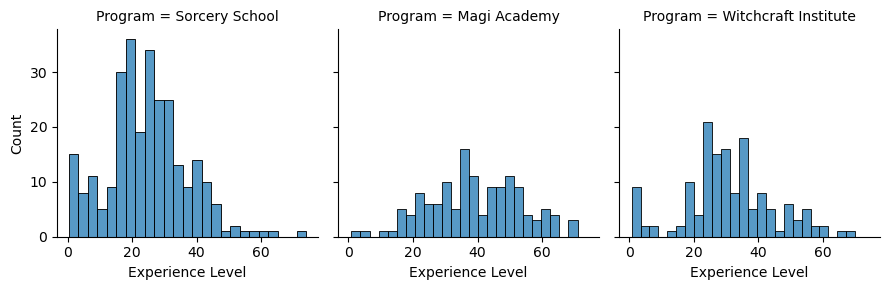

In [108]:
sns.FacetGrid(data = df, col = 'Program').map(sns.histplot, 'Experience Level', bins = 25);

Above we can visualize what was described previously. On average students who apply to Sorcery School have lower experience levels.

In [109]:
df = fill_experience(df)

In [110]:
df = df.reset_index(drop = True)

In [111]:
df = fix_structure(df)

The cell above corrects the error that was present in the string 'Arcan Institute ', it had an extra space at the end of the name.

In [112]:
df.to_csv('treated_df.csv', index = False)

# Predicting The Target

There are a few things we should keep in mind before moving on:
- Student Gender, Experience Level, Program and Financial Background seem to be the most important variables.
- The data had more rows with a 0 classification than 1 this might be a problem.

Due to the imbalance and the overall low quality of the relationships in the dataset we should consider ensemble methods:
- Boosting Models such as AdaBoost aim to decrease bias which occurs when some aspects of the dataset are given more important and/or representation than others which can lead to poor results.
- Bagging Models such as BaggingClassifier tries to decrease variance which is differences that are observed when the model uses different portions of the dataset, high variance will probably perform well in the training set but poor in the test set.
- Stacking tries to decrease both bias and variance by combining the predictions of multiple models before producing the final output.
- VotingClassifier outputs the most predicted results from an ensemble of estimators.

In [113]:
df = pd.read_csv('treated_df.csv')

In [114]:
df = df.reset_index(drop = True)

In [115]:
train_df, X_train, X_test, y_train, y_test = prepare_df(df, target = 'Admitted in School', sample = False, encode = True, 
                                                        columns_to_scale = ['Student Siblings', 'Student Family', 'Financial Background', 'Student Social Influence', 'Experience Level'], 
                                                        columns_to_drop = 'Student ID', stratify = 'Admitted in School')

In [116]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state = 42, stratify = y_test, test_size = 0.25)

## Baseline Performance

Feature selection will probably be important since some features seemed to not have much value, therefore, we will need to get some decent baseline models in order to evaluate their feature importances, as doing so in models that overfit or do generally bad would make the feature importance information less representative.

In [117]:
baseline_test = run_tests(X_train, X_test, y_train, y_test)

In [118]:
baseline_test

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,TEST LOGR,13,0.723288,0.735632,0.868035,0.702128,0.905882,0.680851
1,TEST KNN,13,0.758621,0.658537,0.917889,0.702128,0.905882,0.574468
2,TEST RF,13,1.000000,0.714286,1.000000,1.000000,0.917647,0.638298
3,TEST ADA,13,0.806630,0.738095,0.917889,0.776596,0.929412,0.659574


Besides RF the models didn't seem to overfit, however reducing the max_depth of the RF is probably a good idea. The models also performed considerably worse at classifying 1s than 0s, which isn't a surprise since the labels are imbalanced.

### Logistic Regression

In [119]:
BASE_LOGR_MODEL = LogisticRegression(random_state = 42, class_weight = {0: 0.44, 1: 0.56})

In [120]:
BASE_LOGR_SKF_RESULTS = cross_validate(BASE_LOGR_MODEL, X_train, y_train, output_name = 'BASE LOGR')

In [121]:
BASE_LOGR_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE LOGR Fold: 0,13.0,0.729242,0.702128,0.862745,0.716312,0.837209,0.702128
1,BASE LOGR Fold: 1,13.0,0.729825,0.702128,0.843750,0.737589,0.835294,0.702128
2,BASE LOGR Fold: 2,13.0,0.734982,0.744681,0.851562,0.737589,0.858824,0.744681
3,BASE LOGR Fold: 3,13.0,0.722022,0.708333,0.859375,0.709220,0.823529,0.723404
4,Average,13.0,0.729018,0.714317,0.854358,0.725177,0.838714,0.718085
5,Spread,0.0,0.012961,0.042553,0.018995,0.028369,0.035294,0.042553


Slightly adjusting the class_weight made the model perform more equally throught so analyzing feature coefficients now will probably result in more realistic conclusions.

### KNN

In [122]:
BASE_KNN_MODEL = KNeighborsClassifier(weights = 'distance', n_neighbors = 4, p = 1)

In [123]:
BASE_KNN_SKF_RESULTS = cross_validate(BASE_KNN_MODEL, X_train, y_train, output_name = 'BASE KNN')

In [124]:
BASE_KNN_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE KNN Fold: 0,13.0,1.0,0.696629,1.0,1.0,0.872093,0.659574
1,BASE KNN Fold: 1,13.0,1.0,0.681319,1.0,1.0,0.847059,0.659574
2,BASE KNN Fold: 2,13.0,1.0,0.693878,1.0,1.0,0.800000,0.723404
3,BASE KNN Fold: 3,13.0,1.0,0.634146,1.0,1.0,0.894118,0.553191
4,Average,13.0,1.0,0.676493,1.0,1.0,0.853317,0.648936
5,Spread,0.0,0.0,0.062483,0.0,0.0,0.094118,0.170213


KNN is the most inconsistent when it comes to classifying 1s and overall performance, this model will probably not be great unless feature selection severly helps the problem.

### Random Forest

In [125]:
BASE_RF_MODEL = RandomForestClassifier(random_state = 42, max_depth = 4, class_weight = {0: 0.41, 1: 0.59}, n_estimators = 135)

In [126]:
BASE_RF_SKF_RESULTS = cross_validate(BASE_RF_MODEL, X_train, y_train, output_name = 'BASE RF')

In [127]:
BASE_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF Fold: 0,13.0,0.806084,0.739130,0.937255,0.751773,0.872093,0.723404
1,BASE RF Fold: 1,13.0,0.808664,0.709677,0.906250,0.794326,0.847059,0.702128
2,BASE RF Fold: 2,13.0,0.795699,0.800000,0.894531,0.787234,0.917647,0.765957
3,BASE RF Fold: 3,13.0,0.810409,0.719101,0.925781,0.773050,0.882353,0.680851
4,Average,13.0,0.805214,0.741977,0.915954,0.776596,0.879788,0.718085
5,Spread,0.0,0.014710,0.090323,0.042724,0.042553,0.070588,0.085106


Even without feature selection RF is performing quite well and consistently in general.

### AdaBoost

In [128]:
BASE_ADA_MODEL = AdaBoostClassifier(random_state = 42, n_estimators = 62, learning_rate = 2.15)

In [129]:
BASE_ADA_SKF_RESULTS = cross_validate(BASE_ADA_MODEL, X_train, y_train, output_name = 'BASE ADA')

In [130]:
BASE_ADA_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE ADA Fold: 0,13.0,0.724638,0.688172,0.862745,0.709220,0.837209,0.680851
1,BASE ADA Fold: 1,13.0,0.720000,0.729167,0.863281,0.702128,0.835294,0.744681
2,BASE ADA Fold: 2,13.0,0.716312,0.741573,0.843750,0.716312,0.894118,0.702128
3,BASE ADA Fold: 3,13.0,0.724014,0.688172,0.855469,0.716312,0.835294,0.680851
4,Average,13.0,0.721241,0.711771,0.856311,0.710993,0.850479,0.702128
5,Spread,0.0,0.008326,0.053401,0.019531,0.014184,0.058824,0.063830


AdaBoost isn't super consistent in all splits but is decent enough for us to evaluate the feature importances.

## Feature Selection

There were some features that appeared to not be relevant (Favourite Study Element, Student Social Influence), i'll focus on these 2 features first and if they are unimportant we can remove them and then perform exhaustive feature selection on the smaller set of remaining features.

In [131]:
BASE_LOGR_RES, BASE_LOGR_FI = run_model(BASE_LOGR_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'BASE LOGR', f_importance_df = True)

In [132]:
BASE_RF_RES, BASE_RF_FI = run_model(BASE_RF_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'BASE RF', f_importance_df = True)

In [133]:
BASE_ADA_RES, BASE_ADA_FI = run_model(BASE_ADA_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'BASE ADA', f_importance_df = True)

In [134]:
pd.concat([abs(BASE_LOGR_FI), BASE_RF_FI, BASE_ADA_FI], axis = 1).sort_values('BASE RF Feature Importances')

,BASE LOGR Feature Coefficients,BASE RF Feature Importances,BASE ADA Feature Importances
Favourite Study Element_Fire,0.355792,0.005889,0.000000
Favourite Study Element_Earth,0.218599,0.006682,0.000000
Favourite Study Element_Water,0.177985,0.008744,0.000000
School of Origin_Eldertree Enclave,0.245487,0.016367,0.000000
School of Origin_Mystic Academy,0.173820,0.017437,0.000000
Program_Witchcraft Institute,0.764393,0.018001,0.000000
Student Family,0.136925,0.033428,0.000000
Student Siblings,0.735763,0.036607,0.000000
Student Social Influence,0.129618,0.049299,0.000000
Experience Level,1.335322,0.089910,0.145161


Most important feature:
- LOGR: Student Gender, Program_Sorcery School, Experience Level
- RF: Student Gender, Financial Background, Experience Level
- ADA: Student Gender, Financial Background, Experience Level

As expected favourite study element and student social influence don't appear to be very important. Only LOGR didn't consider favourite study element one of the most irrelevant features.

In [135]:
ft = ['Favourite Study Element_Fire', 'Favourite Study Element_Earth', 'Favourite Study Element_Water', 'Student Social Influence']

In [136]:
irrelavant_features_logr = keep_one_cv(BASE_LOGR_MODEL, ft ,X_train, y_train, output_name = 'BASE LOGR')

In [137]:
irrelavant_features_logr

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Favourite Study Element_Fire,Favourite Study Element_Earth,Favourite Study Element_Water,Student Social Influence
0,Average,13.0,0.729018,0.714317,0.854358,0.725177,0.838714,0.718085,1,1,1,1
1,Subset 0 AVG,12.0,0.722928,0.712641,0.848499,0.721631,0.835773,0.718085,0,1,1,1
2,Subset 1 AVG,12.0,0.727728,0.713832,0.852409,0.725177,0.826949,0.728723,1,0,1,1
3,Subset 2 AVG,12.0,0.723207,0.710947,0.852405,0.718085,0.838714,0.712766,1,1,0,1
4,Subset 3 AVG,12.0,0.722481,0.716205,0.851425,0.718085,0.841655,0.718085,1,1,1,0
5,Subset 4 AVG,11.0,0.723559,0.719532,0.849479,0.721631,0.835773,0.728723,0,0,1,1
6,Subset 5 AVG,11.0,0.721915,0.711164,0.850452,0.718085,0.838714,0.712766,0,1,0,1
7,Subset 6 AVG,11.0,0.722515,0.721307,0.851425,0.718085,0.838714,0.728723,0,1,1,0
8,Subset 7 AVG,11.0,0.724808,0.708980,0.851432,0.721631,0.829891,0.718085,1,0,0,1
9,Subset 8 AVG,11.0,0.722878,0.713832,0.848495,0.721631,0.826949,0.728723,1,0,1,0


These features were clearly unimportant as the performance remained the same regardless of which combination of these features we used or even if we used any of them. In fact not using any of them brought the train and test performance average even close. The worst combination occured when using only favourite study element fire and earth but even this was near identical to the using every feature or not using any of these. The best combination besides dropping them all seemed to be keeping Water and Student Social Influence.

In [138]:
irrelavant_features_rf = keep_one_cv(BASE_RF_MODEL, ft ,X_train, y_train, output_name = 'BASE RF')

In [139]:
irrelavant_features_rf

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Favourite Study Element_Fire,Favourite Study Element_Earth,Favourite Study Element_Water,Student Social Influence
0,Average,13.0,0.805214,0.741977,0.915954,0.776596,0.879788,0.718085,1,1,1,1
1,Subset 0 AVG,12.0,0.804697,0.721791,0.920814,0.769504,0.871067,0.696809,0,1,1,1
2,Subset 1 AVG,12.0,0.806140,0.730721,0.919845,0.773050,0.874008,0.707447,1,0,1,1
3,Subset 2 AVG,12.0,0.807316,0.738148,0.922767,0.771277,0.874008,0.718085,1,1,0,1
4,Subset 3 AVG,12.0,0.805040,0.716495,0.925708,0.764184,0.879788,0.680851,1,1,1,0
5,Subset 4 AVG,11.0,0.795784,0.756898,0.906170,0.773050,0.876915,0.744681,0,0,1,1
6,Subset 5 AVG,11.0,0.793575,0.753644,0.903240,0.773050,0.862209,0.755319,0,1,0,1
7,Subset 6 AVG,11.0,0.792385,0.743357,0.903236,0.771277,0.876881,0.723404,0,1,1,0
8,Subset 7 AVG,11.0,0.793611,0.757572,0.903236,0.773050,0.868092,0.755319,1,0,0,1
9,Subset 8 AVG,11.0,0.788129,0.749115,0.897365,0.771277,0.879822,0.728723,1,0,1,0


There are slightly more differences in RF than LOGR however it's still not very significant. The bigger differences occured in the average for predicting 1s accuracy in the test set. Dropping all of these features decreased the average performance of predicting 0s slightly but it came with a slight increase in the performance when predicting 1s specially in the test set. Dropping all of these features seems to have a positive effect. However, if we were to choose a subset it would once again be Water and Student Social Influence.

In [140]:
irrelavant_features_knn = keep_one_cv(BASE_KNN_MODEL, ft ,X_train, y_train, output_name = 'BASE KNN')

In [141]:
irrelavant_features_knn

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Favourite Study Element_Fire,Favourite Study Element_Earth,Favourite Study Element_Water,Student Social Influence
0,Average,13.0,1.000000,0.676493,1.000000,1.000000,0.853317,0.648936,1,1,1,1
1,Subset 0 AVG,12.0,1.000000,0.722770,1.000000,1.000000,0.859268,0.712766,0,1,1,1
2,Subset 1 AVG,12.0,1.000000,0.662282,1.000000,1.000000,0.847401,0.632979,1,0,1,1
3,Subset 2 AVG,12.0,1.000000,0.682409,1.000000,1.000000,0.862141,0.648936,1,1,0,1
4,Subset 3 AVG,12.0,0.993766,0.641135,0.999023,0.989362,0.838646,0.611702,1,1,1,0
5,Subset 4 AVG,11.0,1.000000,0.718035,1.000000,1.000000,0.847572,0.718085,0,0,1,1
6,Subset 5 AVG,11.0,1.000000,0.709272,1.000000,1.000000,0.859268,0.691489,0,1,0,1
7,Subset 6 AVG,11.0,0.991071,0.651807,0.999023,0.984043,0.826984,0.638298,0,1,1,0
8,Subset 7 AVG,11.0,1.000000,0.672395,1.000000,1.000000,0.850479,0.643617,1,0,0,1
9,Subset 8 AVG,11.0,0.991986,0.631218,0.998047,0.987589,0.821135,0.611702,1,0,1,0


KNN seemed to have benifited the most from this feature selection process. The best subset was also keeping only Water and Student Social Influence.

It's not worth running this process for AdaBoost since the model considered all of these features to be irrelevant as they had a feature importance of 0.

If we only keep Favourite Study Element_Water and Student Social influence we reduce the possible number of combinations from 8190 to 2047 which is reasonable to test out in an exhaustive feature selection process. We also don't lose anything because if these 2 features prove to be irrelevant they'll simply perform worse than the best combination.

In [142]:
X_train = X_train.drop(['Favourite Study Element_Fire', 'Favourite Study Element_Earth'], axis = 1)

In [143]:
X_test = X_test.drop(['Favourite Study Element_Fire', 'Favourite Study Element_Earth'], axis = 1)

In [144]:
relevant_features = list(X_train.columns)

### Exhaustive Feature Selection

#### Logistic Regression

In [145]:
EFS_LOGR = exhaustive_selector(BASE_LOGR_MODEL, relevant_features, X_train, X_test, y_train, y_test, output_name = 'EFS LOGR', task = 'classification')

In [146]:
EFS_LOGR.loc[EFS_LOGR['Features Used'] == 1].sort_values('Train Score')

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Experience Level,Student Siblings,Student Family,Financial Background,Student Social Influence,Program_Sorcery School,Program_Witchcraft Institute,Student Gender_male,School of Origin_Eldertree Enclave,School of Origin_Mystic Academy,Favourite Study Element_Water
0,EFS LOGR,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EFS LOGR,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EFS LOGR,1,0.000000,0.000000,0.985337,0.000000,0.976471,0.000000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EFS LOGR,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6,EFS LOGR,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
9,EFS LOGR,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
10,EFS LOGR,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,EFS LOGR,1,0.180095,0.120000,0.988270,0.101064,1.000000,0.063830,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,EFS LOGR,1,0.351724,0.285714,0.850440,0.271277,0.917647,0.191489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
5,EFS LOGR,1,0.578199,0.571429,0.671554,0.648936,0.670588,0.638298,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In LOGR only Student Gender, Program_Sorcery School, School of Origin_Eldertree Enclave and Financial Background had any predictive capabilities on their own. It's also surprising that Student Gender by itself didn't have a performance much worse than the BASE LOGR model using every feature.

In [147]:
efs_logr_info = expand_info(EFS_LOGR)

In [148]:
BASE_LOGR_SKF_RESULTS.loc[BASE_LOGR_SKF_RESULTS['Model'] == 'Average']

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
4,Average,13.0,0.729018,0.714317,0.854358,0.725177,0.838714,0.718085


In [149]:
efs_logr_info.loc[(efs_logr_info['Train Score'] > 0.71) & (efs_logr_info['Test Score'] > 0.71)]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Train Accuracy Difference,Test Accuracy Difference,Score Difference
1505,EFS LOGR,7,0.710383,0.711111,0.859238,0.691489,0.870588,0.680851,0.167748,0.189737,-0.000729
1819,EFS LOGR,8,0.717391,0.717391,0.859238,0.702128,0.858824,0.702128,0.157110,0.156696,0.000000
1836,EFS LOGR,8,0.727273,0.711111,0.853372,0.723404,0.870588,0.680851,0.129968,0.189737,0.016162
1841,EFS LOGR,8,0.715447,0.711111,0.856305,0.702128,0.870588,0.680851,0.154177,0.189737,0.004336
1843,EFS LOGR,8,0.710383,0.711111,0.859238,0.691489,0.870588,0.680851,0.167748,0.189737,-0.000729
1997,EFS LOGR,9,0.727273,0.711111,0.853372,0.723404,0.870588,0.680851,0.129968,0.189737,0.016162
1999,EFS LOGR,9,0.715447,0.711111,0.856305,0.702128,0.870588,0.680851,0.154177,0.189737,0.004336


Feature selection didn't seem to improve LOGR at all, it actually decreased performance by a bit in every field. But if we were to get the features that performed the best out of this group they would have occured in the row with index 1819.

In [150]:
BEST_LOGR_ROW = pd.DataFrame(EFS_LOGR.loc[1819]).transpose()

In [151]:
BEST_LOGR_FEATURES = extract_features(BEST_LOGR_ROW.iloc[:, 8:21])

In [152]:
BEST_LOGR_FEATURES

['Experience Level',
 'Student Siblings',
 'Student Family',
 'Financial Background',
 'Student Social Influence',
 'Program_Sorcery School',
 'Student Gender_male',
 'School of Origin_Eldertree Enclave']

In [153]:
EFS_LOGR_SKF_RESULTS = cross_validate(BASE_LOGR_MODEL, X_train[BEST_LOGR_FEATURES], y_train, output_name = 'BASE KNN')

In [154]:
EFS_LOGR_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE KNN Fold: 0,8.0,0.713235,0.702128,0.866667,0.687943,0.837209,0.702128
1,BASE KNN Fold: 1,8.0,0.717391,0.694737,0.859375,0.702128,0.823529,0.702128
2,BASE KNN Fold: 2,8.0,0.707581,0.727273,0.851562,0.695035,0.894118,0.680851
3,BASE KNN Fold: 3,8.0,0.715328,0.703297,0.863281,0.695035,0.858824,0.680851
4,Average,8.0,0.713384,0.706858,0.860221,0.695035,0.853420,0.691489
5,Spread,0.0,0.009810,0.032536,0.015104,0.014184,0.070588,0.021277


These features were relatively consistent as shown by the SKF CV above.

The most important features are all here and Student Social Influence was selected, however, Favourite Study Element Water was not.

#### KNN

In [155]:
EFS_KNN = exhaustive_selector(BASE_KNN_MODEL, relevant_features, X_train, X_test, y_train, y_test, output_name = 'EFS KNN', task = 'classification')

In [156]:
EFS_KNN.loc[EFS_KNN['Features Used'] == 1].sort_values('Train Score')

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Experience Level,Student Siblings,Student Family,Financial Background,Student Social Influence,Program_Sorcery School,Program_Witchcraft Institute,Student Gender_male,School of Origin_Eldertree Enclave,School of Origin_Mystic Academy,Favourite Study Element_Water
1,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
8,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
9,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
10,EFS KNN,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,EFS KNN,1,0.279412,0.191781,0.865103,0.202128,0.776471,0.148936,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,EFS KNN,1,0.307087,0.203390,0.920821,0.207447,0.929412,0.127660,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EFS KNN,1,0.438538,0.440000,0.173021,0.702128,0.176471,0.702128,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For KNN Student Gender by itself would have no predictive power, and based on the results no feature by itself would've done even remotely well.

In [157]:
efs_knn_info = expand_info(EFS_KNN)

In [158]:
BASE_KNN_SKF_RESULTS.loc[BASE_KNN_SKF_RESULTS['Model'] == 'Average']

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
4,Average,13.0,1.0,0.676493,1.0,1.0,0.853317,0.648936


In [159]:
efs_knn_info.loc[(efs_knn_info['Train Score'] > 0.8) & (efs_knn_info['Test Score'] > 0.8)]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Train Accuracy Difference,Test Accuracy Difference,Score Difference
182,EFS KNN,3,0.868571,0.818182,0.970674,0.808511,0.941176,0.765957,0.162164,0.175219,0.050390
506,EFS KNN,4,0.871508,0.822222,0.958944,0.829787,0.929412,0.787234,0.129157,0.142178,0.049286


KNN actually performed very well during the EFS method, it produced the best results we've seen until now. It also only used 3/4 features to get these results.

In [160]:
BEST_KNN_ROW = pd.DataFrame(EFS_KNN.loc[506]).transpose()

In [161]:
BEST_KNN_FEATURES = extract_features(BEST_KNN_ROW.iloc[:, 8:21])

In [162]:
BEST_KNN_FEATURES

['Financial Background',
 'Program_Sorcery School',
 'Program_Witchcraft Institute',
 'Student Gender_male']

Student Gender was present however KNN used Finanical Background and Program and not Experience Level which is surprising, i'll check these features with cross validation to see if this was just luck or if it would be consistent.

In [163]:
EFS_KNN_SKF_RESULTS = cross_validate(BASE_KNN_MODEL, X_train[BEST_KNN_FEATURES], y_train, output_name = 'BASE KNN')

In [164]:
EFS_KNN_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE KNN Fold: 0,4.0,0.877863,0.666667,0.976471,0.815603,0.918605,0.574468
1,BASE KNN Fold: 1,4.0,0.886364,0.651685,0.976562,0.829787,0.847059,0.617021
2,BASE KNN Fold: 2,4.0,0.870229,0.691358,0.972656,0.808511,0.929412,0.595745
3,BASE KNN Fold: 3,4.0,0.861660,0.698795,0.988281,0.773050,0.917647,0.617021
4,Average,4.0,0.874029,0.677126,0.978493,0.806738,0.903181,0.601064
5,Spread,0.0,0.024704,0.047110,0.015625,0.056738,0.082353,0.042553


The results were not consistent at all, the performance was always good in the train set but mediocre in the test set, specially when predicting 1s.

#### Random Forest

In [165]:
EFS_RF = exhaustive_selector(BASE_RF_MODEL, relevant_features, X_train, X_test, y_train, y_test, output_name = 'EFS RF', task = 'classification')

In [166]:
EFS_RF.loc[EFS_RF['Features Used'] == 1].sort_values('Train Score')

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Experience Level,Student Siblings,Student Family,Financial Background,Student Social Influence,Program_Sorcery School,Program_Witchcraft Institute,Student Gender_male,School of Origin_Eldertree Enclave,School of Origin_Mystic Academy,Favourite Study Element_Water
6,EFS RF,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
10,EFS RF,1,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,EFS RF,1,0.220339,0.241379,0.935484,0.138298,0.952941,0.148936,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,EFS RF,1,0.351724,0.285714,0.850440,0.271277,0.917647,0.191489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,EFS RF,1,0.385382,0.378378,0.838710,0.308511,0.847059,0.297872,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,EFS RF,1,0.396450,0.309859,0.756598,0.356383,0.847059,0.234043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,EFS RF,1,0.400000,0.467532,0.765396,0.356383,0.858824,0.382979,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,EFS RF,1,0.423208,0.389610,0.873900,0.329787,0.823529,0.319149,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EFS RF,1,0.578199,0.571429,0.671554,0.648936,0.670588,0.638298,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,EFS RF,1,0.630435,0.511628,0.812317,0.617021,0.800000,0.468085,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Student Gender performed decent by itself, this is clearly the best feature.

In [167]:
efs_rf_info = expand_info(EFS_RF)

In [168]:
efs_rf_info

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Train Accuracy Difference,Test Accuracy Difference,Score Difference
0,EFS RF,1,0.423208,0.389610,0.873900,0.329787,0.823529,0.319149,0.544113,0.504380,0.033598
1,EFS RF,1,0.400000,0.467532,0.765396,0.356383,0.858824,0.382979,0.409013,0.475845,-0.067532
2,EFS RF,1,0.385382,0.378378,0.838710,0.308511,0.847059,0.297872,0.530199,0.549186,0.007004
3,EFS RF,1,0.630435,0.511628,0.812317,0.617021,0.800000,0.468085,0.195295,0.331915,0.118807
4,EFS RF,1,0.220339,0.241379,0.935484,0.138298,0.952941,0.148936,0.797186,0.804005,-0.021040
...,...,...,...,...,...,...,...,...,...,...,...
2042,EFS RF,10,0.774011,0.767442,0.914956,0.728723,0.929412,0.702128,0.186233,0.227284,0.006569
2043,EFS RF,10,0.805479,0.744186,0.912023,0.781915,0.917647,0.680851,0.130109,0.236796,0.061293
2044,EFS RF,10,0.795580,0.727273,0.912023,0.765957,0.894118,0.680851,0.146066,0.213267,0.068307
2045,EFS RF,10,0.768802,0.738095,0.903226,0.734043,0.929412,0.659574,0.169183,0.269837,0.030707


In [169]:
BASE_RF_SKF_RESULTS.loc[BASE_RF_SKF_RESULTS['Model'] == 'Average']

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
4,Average,13.0,0.805214,0.741977,0.915954,0.776596,0.879788,0.718085


In [170]:
efs_rf_info.loc[(efs_rf_info['Train Score'] >= 0.78) & (efs_rf_info['Test Score'] >= 0.78) & (efs_rf_info['Test Accuracy 1'] >= 0.72)]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1,Train Accuracy Difference,Test Accuracy Difference,Score Difference
1030,EFS RF,6,0.782609,0.781609,0.894428,0.765957,0.929412,0.723404,0.128471,0.206008,0.001000
1835,EFS RF,8,0.784946,0.781609,0.888563,0.776596,0.929412,0.723404,0.111967,0.206008,0.003337
1996,EFS RF,9,0.780488,0.781609,0.891496,0.765957,0.929412,0.723404,0.125538,0.206008,-0.001121


These 3 instances above did slightly worse in the train set but considerably better in the test set they maintained or increase the accuracy in predicting both 1s and 0s. The improvement was large however since Random Forest choose the best features to split on i wouldn't expect there to be a massive improvement by doing feature selection.

In [171]:
BEST_RF_ROW_1 = pd.DataFrame(EFS_RF.loc[1030]).transpose()
BEST_RF_ROW_2 = pd.DataFrame(EFS_RF.loc[1835]).transpose()
BEST_RF_ROW_3 = pd.DataFrame(EFS_RF.loc[1996]).transpose()

BEST_RF_FEATURES_1 = extract_features(BEST_RF_ROW_1.iloc[:, 8:21])
BEST_RF_FEATURES_2 = extract_features(BEST_RF_ROW_2.iloc[:, 8:21])
BEST_RF_FEATURES_3 = extract_features(BEST_RF_ROW_3.iloc[:, 8:21])

In [172]:
EFS_RF_SKF_RESULTS_1 = cross_validate(BASE_RF_MODEL, X_train[BEST_RF_FEATURES_1], y_train, output_name = 'BASE RF 1')
EFS_RF_SKF_RESULTS_2 = cross_validate(BASE_RF_MODEL, X_train[BEST_RF_FEATURES_2], y_train, output_name = 'BASE RF 2')
EFS_RF_SKF_RESULTS_3 = cross_validate(BASE_RF_MODEL, X_train[BEST_RF_FEATURES_3], y_train, output_name = 'BASE RF 3')

In [173]:
BASE_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF Fold: 0,13.0,0.806084,0.739130,0.937255,0.751773,0.872093,0.723404
1,BASE RF Fold: 1,13.0,0.808664,0.709677,0.906250,0.794326,0.847059,0.702128
2,BASE RF Fold: 2,13.0,0.795699,0.800000,0.894531,0.787234,0.917647,0.765957
3,BASE RF Fold: 3,13.0,0.810409,0.719101,0.925781,0.773050,0.882353,0.680851
4,Average,13.0,0.805214,0.741977,0.915954,0.776596,0.879788,0.718085
5,Spread,0.0,0.014710,0.090323,0.042724,0.042553,0.070588,0.085106


In [174]:
EFS_RF_SKF_RESULTS_1

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 1 Fold: 0,6.0,0.777778,0.744681,0.905882,0.744681,0.860465,0.744681
1,BASE RF 1 Fold: 1,6.0,0.804348,0.744681,0.906250,0.787234,0.858824,0.744681
2,BASE RF 1 Fold: 2,6.0,0.790210,0.774194,0.875000,0.801418,0.882353,0.765957
3,BASE RF 1 Fold: 3,6.0,0.812950,0.739130,0.906250,0.801418,0.870588,0.723404
4,Average,6.0,0.796321,0.750671,0.898346,0.783688,0.868057,0.744681
5,Spread,0.0,0.035172,0.035063,0.031250,0.056738,0.023529,0.042553


The subset 1 with only 6 features wasn't much of an improve but it was consistent during the cross validation.

In [175]:
BASE_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF Fold: 0,13.0,0.806084,0.739130,0.937255,0.751773,0.872093,0.723404
1,BASE RF Fold: 1,13.0,0.808664,0.709677,0.906250,0.794326,0.847059,0.702128
2,BASE RF Fold: 2,13.0,0.795699,0.800000,0.894531,0.787234,0.917647,0.765957
3,BASE RF Fold: 3,13.0,0.810409,0.719101,0.925781,0.773050,0.882353,0.680851
4,Average,13.0,0.805214,0.741977,0.915954,0.776596,0.879788,0.718085
5,Spread,0.0,0.014710,0.090323,0.042724,0.042553,0.070588,0.085106


In [176]:
EFS_RF_SKF_RESULTS_2

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 2 Fold: 0,8.0,0.788104,0.744681,0.913725,0.751773,0.860465,0.744681
1,BASE RF 2 Fold: 1,8.0,0.802920,0.757895,0.910156,0.780142,0.858824,0.765957
2,BASE RF 2 Fold: 2,8.0,0.790036,0.782609,0.886719,0.787234,0.894118,0.765957
3,BASE RF 2 Fold: 3,8.0,0.816176,0.739130,0.921875,0.787234,0.870588,0.723404
4,Average,8.0,0.799309,0.756079,0.908119,0.776596,0.870999,0.750000
5,Spread,0.0,0.028072,0.043478,0.035156,0.035461,0.035294,0.042553


Subset 2 was also consistent and very similiar to subset 1, perhaps slightly better but it's effectively nothing.

In [177]:
BASE_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF Fold: 0,13.0,0.806084,0.739130,0.937255,0.751773,0.872093,0.723404
1,BASE RF Fold: 1,13.0,0.808664,0.709677,0.906250,0.794326,0.847059,0.702128
2,BASE RF Fold: 2,13.0,0.795699,0.800000,0.894531,0.787234,0.917647,0.765957
3,BASE RF Fold: 3,13.0,0.810409,0.719101,0.925781,0.773050,0.882353,0.680851
4,Average,13.0,0.805214,0.741977,0.915954,0.776596,0.879788,0.718085
5,Spread,0.0,0.014710,0.090323,0.042724,0.042553,0.070588,0.085106


In [178]:
EFS_RF_SKF_RESULTS_3

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 3 Fold: 0,9.0,0.791209,0.736842,0.905882,0.765957,0.848837,0.744681
1,BASE RF 3 Fold: 1,9.0,0.800000,0.752688,0.906250,0.780142,0.870588,0.744681
2,BASE RF 3 Fold: 2,9.0,0.784722,0.765957,0.867188,0.801418,0.870588,0.765957
3,BASE RF 3 Fold: 3,9.0,0.804348,0.739130,0.906250,0.787234,0.870588,0.723404
4,Average,9.0,0.795070,0.748655,0.896392,0.783688,0.865150,0.744681
5,Spread,0.0,0.019626,0.029115,0.039062,0.035461,0.021751,0.042553


This was the worst subset but it wasn't by much. Overall all the subsets were consistent during the cross validation process and there wasn't much of an improvement compared to using all the features. However the spread decreased in almost every field which mada the models slightly more consistent which is desirable.

In [179]:
EFS_RF_SKF_RESULTS_1

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 1 Fold: 0,6.0,0.777778,0.744681,0.905882,0.744681,0.860465,0.744681
1,BASE RF 1 Fold: 1,6.0,0.804348,0.744681,0.906250,0.787234,0.858824,0.744681
2,BASE RF 1 Fold: 2,6.0,0.790210,0.774194,0.875000,0.801418,0.882353,0.765957
3,BASE RF 1 Fold: 3,6.0,0.812950,0.739130,0.906250,0.801418,0.870588,0.723404
4,Average,6.0,0.796321,0.750671,0.898346,0.783688,0.868057,0.744681
5,Spread,0.0,0.035172,0.035063,0.031250,0.056738,0.023529,0.042553


In [180]:
EFS_RF_SKF_RESULTS_2

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 2 Fold: 0,8.0,0.788104,0.744681,0.913725,0.751773,0.860465,0.744681
1,BASE RF 2 Fold: 1,8.0,0.802920,0.757895,0.910156,0.780142,0.858824,0.765957
2,BASE RF 2 Fold: 2,8.0,0.790036,0.782609,0.886719,0.787234,0.894118,0.765957
3,BASE RF 2 Fold: 3,8.0,0.816176,0.739130,0.921875,0.787234,0.870588,0.723404
4,Average,8.0,0.799309,0.756079,0.908119,0.776596,0.870999,0.750000
5,Spread,0.0,0.028072,0.043478,0.035156,0.035461,0.035294,0.042553


In [181]:
EFS_RF_SKF_RESULTS_3

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 3 Fold: 0,9.0,0.791209,0.736842,0.905882,0.765957,0.848837,0.744681
1,BASE RF 3 Fold: 1,9.0,0.800000,0.752688,0.906250,0.780142,0.870588,0.744681
2,BASE RF 3 Fold: 2,9.0,0.784722,0.765957,0.867188,0.801418,0.870588,0.765957
3,BASE RF 3 Fold: 3,9.0,0.804348,0.739130,0.906250,0.787234,0.870588,0.723404
4,Average,9.0,0.795070,0.748655,0.896392,0.783688,0.865150,0.744681
5,Spread,0.0,0.019626,0.029115,0.039062,0.035461,0.021751,0.042553


I'd say subset 3 was the best

In [182]:
BEST_RF_FEATURES_3

['Experience Level',
 'Student Siblings',
 'Student Family',
 'Financial Background',
 'Program_Sorcery School',
 'Program_Witchcraft Institute',
 'Student Gender_male',
 'School of Origin_Eldertree Enclave',
 'Favourite Study Element_Water']

There's not much of a surprise in the features present, all of the most important ones were here.

#### AdaBoost

AdaBoost was only using 3 features already so it doesn't make sense to run this process.

### Selecting Features

In [183]:
BEST_LOGR_FEATURES

['Experience Level',
 'Student Siblings',
 'Student Family',
 'Financial Background',
 'Student Social Influence',
 'Program_Sorcery School',
 'Student Gender_male',
 'School of Origin_Eldertree Enclave']

In [184]:
BEST_RF_FEATURES_3

['Experience Level',
 'Student Siblings',
 'Student Family',
 'Financial Background',
 'Program_Sorcery School',
 'Program_Witchcraft Institute',
 'Student Gender_male',
 'School of Origin_Eldertree Enclave',
 'Favourite Study Element_Water']

- LOGR used Student Social Influence which RF didn't
- RF used Favourite Study Element_Water, Program_Witchcraft Institute which LOGR didn't

In [185]:
EFS_LOGR_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE KNN Fold: 0,8.0,0.713235,0.702128,0.866667,0.687943,0.837209,0.702128
1,BASE KNN Fold: 1,8.0,0.717391,0.694737,0.859375,0.702128,0.823529,0.702128
2,BASE KNN Fold: 2,8.0,0.707581,0.727273,0.851562,0.695035,0.894118,0.680851
3,BASE KNN Fold: 3,8.0,0.715328,0.703297,0.863281,0.695035,0.858824,0.680851
4,Average,8.0,0.713384,0.706858,0.860221,0.695035,0.853420,0.691489
5,Spread,0.0,0.009810,0.032536,0.015104,0.014184,0.070588,0.021277


In [186]:
EFS_RF_SKF_RESULTS_3

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,BASE RF 3 Fold: 0,9.0,0.791209,0.736842,0.905882,0.765957,0.848837,0.744681
1,BASE RF 3 Fold: 1,9.0,0.800000,0.752688,0.906250,0.780142,0.870588,0.744681
2,BASE RF 3 Fold: 2,9.0,0.784722,0.765957,0.867188,0.801418,0.870588,0.765957
3,BASE RF 3 Fold: 3,9.0,0.804348,0.739130,0.906250,0.787234,0.870588,0.723404
4,Average,9.0,0.795070,0.748655,0.896392,0.783688,0.865150,0.744681
5,Spread,0.0,0.019626,0.029115,0.039062,0.035461,0.021751,0.042553


RF performed significantly better therefore the relevant features will be the ones used by this model.

In [187]:
X_train = X_train[BEST_RF_FEATURES_3]
X_test = X_test[BEST_RF_FEATURES_3]
X_val = X_val[BEST_RF_FEATURES_3]

## Model Tuning

### Logistic Regression

In [188]:
FINAL_LOGR_MODEL = LogisticRegression(random_state = 42, class_weight = {0: 0.42, 1: 0.58}, C = 8)

In [189]:
FINAL_LOGR_SKF_RESULTS = cross_validate(FINAL_LOGR_MODEL, X_train, y_train, output_name = 'FINAL LOGR')

In [190]:
FINAL_LOGR_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL LOGR Fold: 0,9.0,0.750877,0.702128,0.854902,0.758865,0.837209,0.702128
1,FINAL LOGR Fold: 1,9.0,0.747405,0.734694,0.843750,0.765957,0.823529,0.765957
2,FINAL LOGR Fold: 2,9.0,0.717241,0.750000,0.824219,0.737589,0.847059,0.765957
3,FINAL LOGR Fold: 3,9.0,0.736111,0.740000,0.839844,0.751773,0.811765,0.787234
4,Average,9.0,0.737909,0.731705,0.840679,0.753546,0.829891,0.755319
5,Spread,0.0,0.033636,0.047872,0.030683,0.028369,0.035294,0.085106


### KNN

In [191]:
FINAL_KNN_MODEL = KNeighborsClassifier(weights = 'distance', n_neighbors = 10, p = 1)

In [192]:
FINAL_KNN_SKF_RESULTS = cross_validate(FINAL_KNN_MODEL, X_train, y_train, output_name = 'FINAL KNN')

In [193]:
FINAL_KNN_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL KNN Fold: 0,9.0,0.989247,0.736842,1.000000,0.978723,0.848837,0.744681
1,FINAL KNN Fold: 1,9.0,0.992908,0.666667,0.996094,0.992908,0.847059,0.638298
2,FINAL KNN Fold: 2,9.0,0.989324,0.777778,0.996094,0.985816,0.905882,0.744681
3,FINAL KNN Fold: 3,9.0,0.982079,0.666667,0.996094,0.971631,0.847059,0.638298
4,Average,9.0,0.988389,0.711988,0.997070,0.982270,0.862209,0.691489
5,Spread,0.0,0.010829,0.111111,0.003906,0.021277,0.058824,0.106383


### AdaBoost

In [194]:
FINAL_ADA_MODEL = AdaBoostClassifier(random_state = 42, n_estimators = 31, learning_rate = 1.44)

In [195]:
FINAL_ADA_SKF_RESULTS = cross_validate(FINAL_ADA_MODEL, X_train, y_train, output_name = 'FINAL ADA')

In [196]:
FINAL_ADA_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA Fold: 0,9.0,0.779412,0.744681,0.901961,0.751773,0.860465,0.744681
1,FINAL ADA Fold: 1,9.0,0.815884,0.673684,0.910156,0.801418,0.811765,0.680851
2,FINAL ADA Fold: 2,9.0,0.778571,0.769231,0.882812,0.773050,0.894118,0.744681
3,FINAL ADA Fold: 3,9.0,0.801444,0.729167,0.902344,0.787234,0.835294,0.744681
4,Average,9.0,0.793828,0.729191,0.899318,0.778369,0.850410,0.728723
5,Spread,0.0,0.037313,0.095547,0.027344,0.049645,0.082353,0.063830


In [197]:
FINAL_ADA_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA Fold: 0,9.0,0.779412,0.744681,0.901961,0.751773,0.860465,0.744681
1,FINAL ADA Fold: 1,9.0,0.815884,0.673684,0.910156,0.801418,0.811765,0.680851
2,FINAL ADA Fold: 2,9.0,0.778571,0.769231,0.882812,0.773050,0.894118,0.744681
3,FINAL ADA Fold: 3,9.0,0.801444,0.729167,0.902344,0.787234,0.835294,0.744681
4,Average,9.0,0.793828,0.729191,0.899318,0.778369,0.850410,0.728723
5,Spread,0.0,0.037313,0.095547,0.027344,0.049645,0.082353,0.063830


### Random Forest

In [198]:
FINAL_RF_MODEL = RandomForestClassifier(random_state = 42, max_depth = 4, class_weight = {0: 0.4, 1: 0.6}, max_leaf_nodes = 9, n_estimators = 45)

In [199]:
FINAL_RF_SKF_RESULTS = cross_validate(FINAL_RF_MODEL, X_train, y_train, output_name = 'FINAL RF')

In [200]:
FINAL_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL RF Fold: 0,9.0,0.776978,0.750000,0.886275,0.765957,0.848837,0.765957
1,FINAL RF Fold: 1,9.0,0.785455,0.752688,0.898438,0.765957,0.870588,0.744681
2,FINAL RF Fold: 2,9.0,0.767123,0.765957,0.847656,0.794326,0.870588,0.765957
3,FINAL RF Fold: 3,9.0,0.804270,0.744681,0.894531,0.801418,0.858824,0.744681
4,Average,9.0,0.783457,0.753332,0.881725,0.781915,0.862209,0.755319
5,Spread,0.0,0.037147,0.021277,0.050781,0.035461,0.021751,0.021277


## Final Adjustments

In this section i'll check the performance of these models on the test set and make some final adjustments if needed. After this i'll get the final performance metrics on the evaluation set.

### LOGR

In [201]:
FINAL_LOGR_RES = run_model(FINAL_LOGR_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'FINAL LOGR RES', f_importance_df = False)

In [202]:
FINAL_LOGR_RES.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL LOGR RES,9,0.728682,0.711111,0.829912,0.75,0.870588,0.680851


In [203]:
FINAL_LOGR_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL LOGR Fold: 0,9.0,0.750877,0.702128,0.854902,0.758865,0.837209,0.702128
1,FINAL LOGR Fold: 1,9.0,0.747405,0.734694,0.843750,0.765957,0.823529,0.765957
2,FINAL LOGR Fold: 2,9.0,0.717241,0.750000,0.824219,0.737589,0.847059,0.765957
3,FINAL LOGR Fold: 3,9.0,0.736111,0.740000,0.839844,0.751773,0.811765,0.787234
4,Average,9.0,0.737909,0.731705,0.840679,0.753546,0.829891,0.755319
5,Spread,0.0,0.033636,0.047872,0.030683,0.028369,0.035294,0.085106


- LOGR did worse on the test set than the average was during the SKF process.

### KNN

In [204]:
FINAL_KNN_RES = run_model(FINAL_KNN_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'FINAL KNN RES', f_importance_df = False)

In [205]:
FINAL_KNN_RES.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL KNN RES,9,0.986595,0.695652,0.997067,0.978723,0.847059,0.680851


In [206]:
FINAL_KNN_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL KNN Fold: 0,9.0,0.989247,0.736842,1.000000,0.978723,0.848837,0.744681
1,FINAL KNN Fold: 1,9.0,0.992908,0.666667,0.996094,0.992908,0.847059,0.638298
2,FINAL KNN Fold: 2,9.0,0.989324,0.777778,0.996094,0.985816,0.905882,0.744681
3,FINAL KNN Fold: 3,9.0,0.982079,0.666667,0.996094,0.971631,0.847059,0.638298
4,Average,9.0,0.988389,0.711988,0.997070,0.982270,0.862209,0.691489
5,Spread,0.0,0.010829,0.111111,0.003906,0.021277,0.058824,0.106383


- KNN performed slightly worse in the test set than it did during the SKF process.

### Random Forest

In [207]:
FINAL_RF_RES = run_model(FINAL_RF_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'FINAL RF RES', f_importance_df = False)

In [208]:
FINAL_RF_RES.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL RF RES,9,0.772973,0.755556,0.88563,0.760638,0.894118,0.723404


In [209]:
FINAL_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL RF Fold: 0,9.0,0.776978,0.750000,0.886275,0.765957,0.848837,0.765957
1,FINAL RF Fold: 1,9.0,0.785455,0.752688,0.898438,0.765957,0.870588,0.744681
2,FINAL RF Fold: 2,9.0,0.767123,0.765957,0.847656,0.794326,0.870588,0.765957
3,FINAL RF Fold: 3,9.0,0.804270,0.744681,0.894531,0.801418,0.858824,0.744681
4,Average,9.0,0.783457,0.753332,0.881725,0.781915,0.862209,0.755319
5,Spread,0.0,0.037147,0.021277,0.050781,0.035461,0.021751,0.021277


- RF had a similiar performance in the test set and in the SKF.

### AdaBoost

In [210]:
FINAL_ADA_RES = run_model(FINAL_ADA_MODEL, X_train, X_test, y_train, y_test, task = 'classification', output_df = True, output_name = 'FINAL ADA RES', f_importance_df = False)

In [211]:
FINAL_ADA_RES.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA RES,9,0.8,0.769231,0.900293,0.787234,0.894118,0.744681


In [212]:
FINAL_ADA_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA Fold: 0,9.0,0.779412,0.744681,0.901961,0.751773,0.860465,0.744681
1,FINAL ADA Fold: 1,9.0,0.815884,0.673684,0.910156,0.801418,0.811765,0.680851
2,FINAL ADA Fold: 2,9.0,0.778571,0.769231,0.882812,0.773050,0.894118,0.744681
3,FINAL ADA Fold: 3,9.0,0.801444,0.729167,0.902344,0.787234,0.835294,0.744681
4,Average,9.0,0.793828,0.729191,0.899318,0.778369,0.850410,0.728723
5,Spread,0.0,0.037313,0.095547,0.027344,0.049645,0.082353,0.063830


- AdaBoost slightly better in the test set.

#### Adjusting LOGR

In [213]:
X = pd.concat([X_train, X_test])

In [214]:
y = pd.concat([y_train, y_test])

In [215]:
FINAL_LOGR_MODEL_ADJ = LogisticRegression(random_state = 42, class_weight = {0: 0.41, 1: 0.59}, C = 9)

In [216]:
FINAL_LOGR_SKF = cross_validate(FINAL_LOGR_MODEL_ADJ, X, y, output_name = 'FINAL LOGR')

In [217]:
FINAL_LOGR_SKF

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL LOGR Fold: 0,9.0,0.725714,0.737705,0.852665,0.721591,0.831776,0.762712
1,FINAL LOGR Fold: 1,9.0,0.717514,0.756303,0.840625,0.721591,0.858491,0.762712
2,FINAL LOGR Fold: 2,9.0,0.726761,0.716667,0.843750,0.732955,0.830189,0.728814
3,FINAL LOGR Fold: 3,9.0,0.739130,0.719298,0.827586,0.768362,0.859813,0.706897
4,Average,9.0,0.727280,0.732493,0.841156,0.736124,0.845067,0.740283
5,Spread,0.0,0.021616,0.039636,0.025078,0.046771,0.029624,0.055815


In [218]:
FINAL_LOGR_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL LOGR Fold: 0,9.0,0.750877,0.702128,0.854902,0.758865,0.837209,0.702128
1,FINAL LOGR Fold: 1,9.0,0.747405,0.734694,0.843750,0.765957,0.823529,0.765957
2,FINAL LOGR Fold: 2,9.0,0.717241,0.750000,0.824219,0.737589,0.847059,0.765957
3,FINAL LOGR Fold: 3,9.0,0.736111,0.740000,0.839844,0.751773,0.811765,0.787234
4,Average,9.0,0.737909,0.731705,0.840679,0.753546,0.829891,0.755319
5,Spread,0.0,0.033636,0.047872,0.030683,0.028369,0.035294,0.085106


After adjusting LOGR was able to performed identically with the test set across all folds as it was doing without it.

#### Adjusting KNN

In [219]:
FINAL_KNN_MODEL_ADJ = KNeighborsClassifier(n_neighbors = 6, p = 1.1, weights = 'distance')

In [220]:
FINAL_KNN_SKF = cross_validate(FINAL_KNN_MODEL_ADJ, X, y, output_name = 'FINAL KNN')

In [221]:
FINAL_KNN_SKF

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL KNN Fold: 0,9.0,0.988506,0.746032,1.000000,0.977273,0.813084,0.796610
1,FINAL KNN Fold: 1,9.0,0.991453,0.715596,0.996875,0.988636,0.896226,0.661017
2,FINAL KNN Fold: 2,9.0,0.979827,0.685714,0.996875,0.965909,0.905660,0.610169
3,FINAL KNN Fold: 3,9.0,0.985755,0.700855,0.996865,0.977401,0.831776,0.706897
4,Average,9.0,0.986385,0.712049,0.997654,0.977305,0.861687,0.693673
5,Spread,0.0,0.011626,0.060317,0.003135,0.022727,0.092576,0.186441


In [222]:
FINAL_KNN_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL KNN Fold: 0,9.0,0.989247,0.736842,1.000000,0.978723,0.848837,0.744681
1,FINAL KNN Fold: 1,9.0,0.992908,0.666667,0.996094,0.992908,0.847059,0.638298
2,FINAL KNN Fold: 2,9.0,0.989324,0.777778,0.996094,0.985816,0.905882,0.744681
3,FINAL KNN Fold: 3,9.0,0.982079,0.666667,0.996094,0.971631,0.847059,0.638298
4,Average,9.0,0.988389,0.711988,0.997070,0.982270,0.862209,0.691489
5,Spread,0.0,0.010829,0.111111,0.003906,0.021277,0.058824,0.106383


- KNN wasn't very consistent and it's still not consistent enough to be good on it's own. I chose to add weights to the algorithm as without it the algorithm was performing just as poor and it was less interesting, maybe combined with other algorithms knn may offer something, if it doesn't it won't be selected for sure.

#### Adjusting RF

In [223]:
FINAL_RF_MODEL_ADJ = RandomForestClassifier(random_state = 42, max_depth = 4, class_weight = {0: 0.4, 1: 0.6}, max_leaf_nodes = 8, n_estimators = 38, min_samples_leaf = 4)

In [224]:
FINAL_RF_SKF = cross_validate(FINAL_RF_MODEL_ADJ, X, y, output_name = 'FINAL RF')

In [225]:
FINAL_RF_SKF

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL RF Fold: 0,9.0,0.761062,0.768000,0.893417,0.732955,0.831776,0.813559
1,FINAL RF Fold: 1,9.0,0.775862,0.775862,0.884375,0.767045,0.886792,0.762712
2,FINAL RF Fold: 2,9.0,0.771930,0.705882,0.893750,0.750000,0.830189,0.711864
3,FINAL RF Fold: 3,9.0,0.775623,0.725664,0.862069,0.790960,0.869159,0.706897
4,Average,9.0,0.771119,0.743852,0.883403,0.760240,0.854479,0.748758
5,Spread,0.0,0.014800,0.069980,0.031681,0.058006,0.056604,0.106663


In [226]:
FINAL_RF_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL RF Fold: 0,9.0,0.776978,0.750000,0.886275,0.765957,0.848837,0.765957
1,FINAL RF Fold: 1,9.0,0.785455,0.752688,0.898438,0.765957,0.870588,0.744681
2,FINAL RF Fold: 2,9.0,0.767123,0.765957,0.847656,0.794326,0.870588,0.765957
3,FINAL RF Fold: 3,9.0,0.804270,0.744681,0.894531,0.801418,0.858824,0.744681
4,Average,9.0,0.783457,0.753332,0.881725,0.781915,0.862209,0.755319
5,Spread,0.0,0.037147,0.021277,0.050781,0.035461,0.021751,0.021277


There was a slight performance decrease in by introducing the test setm however the model is still reasonably consistent, i'd like if the spreads were lower meaning a higher consistency across all splits, however it's still not a bad performing model.

#### Adjusting AdaBoost

In [227]:
FINAL_ADA_MODEL_ADJ = AdaBoostClassifier(random_state = 42, n_estimators = 57, learning_rate = 1.61)

In [228]:
FINAL_ADA_SKF = cross_validate(FINAL_ADA_MODEL_ADJ, X, y, output_name = 'FINAL ADA')

In [229]:
FINAL_ADA_SKF

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA Fold: 0,9.0,0.777448,0.731707,0.905956,0.744318,0.822430,0.762712
1,FINAL ADA Fold: 1,9.0,0.812500,0.706897,0.896875,0.812500,0.849057,0.694915
2,FINAL ADA Fold: 2,9.0,0.830946,0.731707,0.912500,0.823864,0.820755,0.762712
3,FINAL ADA Fold: 3,9.0,0.841499,0.756757,0.924765,0.824859,0.897196,0.724138
4,Average,9.0,0.815598,0.731767,0.910024,0.801385,0.847359,0.736119
5,Spread,0.0,0.064050,0.049860,0.027890,0.080541,0.076442,0.067797


In [230]:
FINAL_ADA_SKF_RESULTS

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA Fold: 0,9.0,0.779412,0.744681,0.901961,0.751773,0.860465,0.744681
1,FINAL ADA Fold: 1,9.0,0.815884,0.673684,0.910156,0.801418,0.811765,0.680851
2,FINAL ADA Fold: 2,9.0,0.778571,0.769231,0.882812,0.773050,0.894118,0.744681
3,FINAL ADA Fold: 3,9.0,0.801444,0.729167,0.902344,0.787234,0.835294,0.744681
4,Average,9.0,0.793828,0.729191,0.899318,0.778369,0.850410,0.728723
5,Spread,0.0,0.037313,0.095547,0.027344,0.049645,0.082353,0.063830


After the adjustments AdaBoost performed slightly better than the model without the test set, it's also consistent in predicting both 0s and 1s across all splits, i'd like the accuracy to be higher however i'd rather have slightly less accuraccy and high consistency the than very high accuracy in one of the splits and poor accuracy in the others.

### Voting Classifier

In [231]:
FINAL_VC_MODEL = VotingClassifier(estimators = [('LOGR', FINAL_LOGR_MODEL_ADJ), ('RF', FINAL_RF_MODEL_ADJ), ('ADA', FINAL_ADA_MODEL_ADJ)], weights = [1, 1, 1])

In [232]:
FINAL_VC_SKF = cross_validate(FINAL_VC_MODEL, X, y, output_name = 'FINAL VC')

In [233]:
FINAL_VC_SKF

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL VC Fold: 0,9.0,0.762463,0.761905,0.890282,0.738636,0.822430,0.813559
1,FINAL VC Fold: 1,9.0,0.768362,0.775862,0.868750,0.772727,0.886792,0.762712
2,FINAL VC Fold: 2,9.0,0.767908,0.739496,0.878125,0.761364,0.849057,0.745763
3,FINAL VC Fold: 3,9.0,0.793388,0.750000,0.868339,0.813559,0.887850,0.724138
4,Average,9.0,0.773030,0.756816,0.876374,0.771572,0.861532,0.761543
5,Spread,0.0,0.030925,0.036366,0.021944,0.074923,0.065421,0.089421


Combining LOGR, RF and ADA in a voting classifier (VC) improved the results but not by much RF on it's own was already getting near identical results.

## Model Selection

In this section i'll perform the final test for each model, i'll test on the x_val and y_val which have not been used in training or tuning for any of these models and evaluate the final metrics. This evaluation set is about 6% (45 rows) out of the total 706 rows of data that we available.

### Logistic Regression

In [234]:
FINAL_LOGR_VAL = run_model(FINAL_LOGR_MODEL_ADJ, X, X_val, y, y_val, task = 'classification', output_df = True, output_name = 'FINAL LOGR VAL', f_importance_df = False)

In [235]:
FINAL_LOGR_VAL.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL LOGR VAL,9,0.728421,0.787879,0.842723,0.73617,0.862069,0.8125


Logistic Regression performed better in the unseen validation set than it did in the training set, getting accuracies above 80% for both labels.

### KNN

In [236]:
FINAL_KNN_VAL = run_model(FINAL_KNN_MODEL_ADJ, X, X_val, y, y_val, task = 'classification', output_df = True, output_name = 'FINAL KNN VAL', f_importance_df = False)

In [237]:
FINAL_KNN_VAL.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL KNN VAL,9,0.982759,0.689655,0.997653,0.970213,0.896552,0.625


As expected KNN didn't perform great.

### Random Forest

In [238]:
FINAL_RF_VAL = run_model(FINAL_RF_MODEL_ADJ, X, X_val, y, y_val, task = 'classification', output_df = True, output_name = 'FINAL RF VAL', f_importance_df = False)

In [239]:
FINAL_RF_VAL.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL RF VAL,9,0.775599,0.787879,0.892019,0.757447,0.862069,0.8125


RF had the same exact performance on the unsee validation set as LOGR did, it did however perform better on the training set.

### AdaBoost

In [240]:
FINAL_ADA_VAL = run_model(FINAL_ADA_MODEL_ADJ, X, X_val, y, y_val, task = 'classification', output_df = True, output_name = 'FINAL ADA VAL', f_importance_df = False)

In [241]:
FINAL_ADA_VAL.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL ADA VAL,9,0.814499,0.8,0.899061,0.812766,0.931034,0.75


AdaBoost achieved the highest f1 score in the validation set of any of the models, however, it did so by outperforming the other models in the accuracy of the 0 label prediction and performing worse in the accuracy of the 1 label predictions.

### Voting Classifier

In [242]:
FINAL_VC_VAL = run_model(FINAL_VC_MODEL, X, X_val, y, y_val, task = 'classification', output_df = True, output_name = 'FINAL VC VAL', f_importance_df = False)

In [243]:
FINAL_VC_VAL.iloc[:,:8]

,Model,Features Used,Train Score,Test Score,Train Accuracy 0,Train Accuracy 1,Test Accuracy 0,Test Accuracy 1
0,FINAL VC VAL,9,0.775862,0.83871,0.884977,0.765957,0.931034,0.8125


The VotingClassifier which combined LOGR, RF and ADA had the best performance it kept AdaBoost's high accuracy of 93% in predicting 0s correctly however it added the good accuracy of 0.81% of LOGR and RF in predicting 1s. This was the best model and it makes sense since it combined good characteristics of a lot of models.

# Predicting on the test dataset

In [244]:
FINAL_MODEL = FINAL_VC_MODEL

In [245]:
FINAL_VC_MODEL.fit(X, y)

VotingClassifier(estimators=[('LOGR',
                              LogisticRegression(C=9,
                                                 class_weight={0: 0.41,
                                                               1: 0.59},
                                                 random_state=42)),
                             ('RF',
                              RandomForestClassifier(class_weight={0: 0.4,
                                                                   1: 0.6},
                                                     max_depth=4,
                                                     max_leaf_nodes=8,
                                                     min_samples_leaf=4,
                                                     n_estimators=38,
                                                     random_state=42)),
                             ('ADA',
                              AdaBoostClassifier(learning_rate=1.61,
                                                 n

In [246]:
test_set = pd.read_csv('Project_test_dataset.csv')

In [247]:
percent_missing(test_set)

,Percent Missing
Experience Level,17
School Dormitory,72


The test dataset has missing values on the same columns that the training set did, and it also needs to be prepared to contain only the same features that we used during the fitting of the model. The features will also need to be encoded or scaled depending on the data type they are. To do all of this we will use the functions created previously.

In [248]:
relevant_features = ['Experience Level', 'Student Siblings', 'Student Family', 'Financial Background', 'Program_Sorcery School', 'Program_Witchcraft Institute', 'Student Gender_male', 'School of Origin_Eldertree Enclave', 'Favourite Study Element_Water']

In [249]:
final_df = fill_experience(test_set).sort_index()

In [250]:
final_df = final_df.drop('School Dormitory', axis = 1)

In [251]:
final_df = encode_df(final_df, drop_first = True)

In [252]:
final_df = final_df[relevant_features]

In [253]:
test_set['Admitted in School'] = FINAL_MODEL.predict(final_df)

In [254]:
test_set = test_set[['Student ID', 'Admitted in School']]

In [255]:
test_set

,Student ID,Admitted in School
0,836,1
1,323,0
2,117,0
3,444,0
4,619,1
...,...,...
171,21,0
172,366,0
173,890,0
174,749,0


In [256]:
test_set.to_csv('test_set_predictions.csv', index = False)